## Homework #3M. Exploratory Data Analysis
#### Author: ULIANA ZBEZHKHOVSKA
#### Total time spent on h/w (in minutes): 900


In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, avg, when, split, count,  monotonically_increasing_id, to_date, date_format, udf, when, year, month, expr, lower, max, size
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

sc = pyspark.SparkContext('local[*]') 
spark = SparkSession(sc)
spark

In [3]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
%matplotlib notebook

*Перед початком роботи я обєднала всі телеграм чати в один файл, і оскільки файл вийшов досить великим для роботи з ним буду використовувати pySpark.*

In [6]:
start_time = datetime.now()
df = spark.read.csv("df_merged.csv", header=True, multiLine=True)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
print('Shape:', df.count(), len(df.columns))

Duration: 0:00:00.109023
Shape: 8427053 14


In [5]:
df.show(5)

+---+----------+-------+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+--------------+-------------+----------+
|_c0|Unnamed: 0|     id|                date| views|           reactions|               to_id|            fwd_from|             message| type|duration|frw_from_title|frw_from_name|msg_entity|
+---+----------+-------+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+--------------+-------------+----------+
|  0|         0|12602.0|2022-12-19 13:05:...|3645.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇵🇰🇦🇫 Исламаба...|photo|    NULL|          NULL|         NULL|      NULL|
|  1|         1|12601.0|2022-12-19 09:52:...|5831.0|MessageReactions(...|PeerChannel(chann...|                NULL|🕯️ 6 лет назад, ...|photo|    NULL|          NULL|         NULL|      NULL|
|  2|         2|12600.0|2022-12-19 09:18:...|

##### Загалом наш датасет включає в себе наступні колонки з даними:
1. _с0 - індекси рядків
2. Unnamed: 0 - також індекси рядків, як в попередній колонці, тому в подальшому планую залишити лише одну з них
3. id - унікальний ідентифікатор для кожного повідомлення
4. date - дата написання повідомлення
5. views - кількість переглядів для кожного повідомлення
6. reactions - реації, які були посталенні на повідомлення (однак така функція була додана у телеграм починаючи з 2021 року)
7.  to_id - колонка, яка показує кому було відправлено повідомлення (id каналу)
8. fwd_from - якщо повідомлення було переслане, то в колонці вказується id від кого
9. message - саме повідомлення 
10. type - тип повідомлення (текст, фото, відео, аудіо)
11. duration - якщо повідомлення аудіо чи відео формату, то тут буде вказана його тривалість
12. frw_from_title - назва каналу
13. frw_from_name - назва каналу звідки переслане повідомлення
14. msg_entity - не зовсім зрозуміло, в описі вказано, що колонка не містить корисної інформації і може бути видалена

#### Проведемо загальний аналіз телеграм груп та дамо відповіді на наступні запитання:
1. Яка група має найбільше комінікацій з іншими? 
2. Яка група не має комунікацій? 
3. Які групи мають комунікації лише одна з одною?
4. Яка група має найбільше вхідних комунікацій?
5. Які група має найбільше вихідних комунікацій?

*Для цього візьмемо лише необхідні колонки id, to_id, fwd_from*

In [42]:
graph = df.select('id', 'to_id', 'fwd_from' ).na.drop()

In [43]:
graph.show(5)

+-------+--------------------+--------------------+
|     id|               to_id|            fwd_from|
+-------+--------------------+--------------------+
|12599.0|PeerChannel(chann...|MessageFwdHeader(...|
|12595.0|PeerChannel(chann...|MessageFwdHeader(...|
|12593.0|PeerChannel(chann...|MessageFwdHeader(...|
|12591.0|PeerChannel(chann...|MessageFwdHeader(...|
|12571.0|PeerChannel(chann...|MessageFwdHeader(...|
+-------+--------------------+--------------------+
only showing top 5 rows



*Створимо Spark функцію для витягування цифрового номеру каналу з колонок повідомлень to_id та fwd_from*

In [44]:
def extract_channel_id(message):
    try:
        start = message.find("channel_id=") + len("channel_id=")
        end = message.find(")", start)
        channel_id = int(message[start:end])
        return channel_id
    except:
        return None

extract_channel_id_udf = udf(extract_channel_id, IntegerType())

df_with_channel_id = graph.withColumn("channel_id_forward", extract_channel_id_udf(graph["fwd_from"]))
df_with_channel_id = df_with_channel_id.withColumn("channel_id_to", extract_channel_id_udf(graph["to_id"]))

In [45]:
graph_df = df_with_channel_id.select('channel_id_forward', 'channel_id_to')

*Згрупуємо отриману інформацію та порахуємо кількість взаємодій між каналами*

In [46]:
ff = graph_df.groupBy("channel_id_to", "channel_id_forward").count().orderBy("count", ascending=False).na.drop()
ff.show()

+-------------+------------------+-----+
|channel_id_to|channel_id_forward|count|
+-------------+------------------+-----+
|   1310493808|        1394050290|17987|
|   1082084045|        1036362176|15206|
|   1082084045|        1069772626|13107|
|   1082084045|        1394050290|10632|
|   1082084045|        1126629353|10329|
|   1166834860|        1009232144| 7765|
|   1082084045|        1341061255| 7375|
|   1082084045|        1098321028| 6442|
|   1216878621|        1394050290| 5731|
|   1315735637|        1126629353| 5642|
|   1315735637|        1373538917| 5136|
|   1450141660|        1335635435| 5121|
|   1082084045|        1213234440| 4801|
|   1082084045|        1029095426| 4580|
|   1418299591|        1101170442| 4468|
|   1082084045|        1046446760| 4420|
|   1246399946|        1647639783| 4155|
|   1144015339|        1140991878| 4012|
|   1082084045|        1443124285| 3954|
|   1082084045|        1115468824| 3748|
+-------------+------------------+-----+
only showing top

*Для зручнішої подальшої відповіді на поставлені запитанні переведено таблицю в Pandas*

In [47]:
pd_graph = ff.toPandas()

*Визначимо чи є групи які взагалі немають комунікацій один з одним*

In [48]:
pd_graph.tail()

channel_id_to  channel_id_forward  count
108298     1135021433          1379352700      1
108299     1113237212          1353067021      1
108300     1217080686          1366622396      1
108301     1217080686          1146577083      1
108302     1217080686          1249813253      1

*Як ми бачимо наша таблиця має 108302 унікальні значення, що є дуже значним. Також є багато груп я мають невелику кількість взаємодій.
Тому для подальшого аналізу залишимо лише ті пари груп, де комунікацій більше 3000.*

In [49]:
pd_graph_100 = pd_graph[pd_graph['count'] > 3000]

In [50]:
pd_graph_100.shape

(36, 3)

*Як бачимо таких груп у нас лише 36, тому зручним буде зробити візуалізацію комунікацій між групами у вигляді графу*

In [51]:
import networkx as nx
from pyvis.network import Network

# Створюємо граф (DiGraph) в networkx
G = nx.DiGraph()



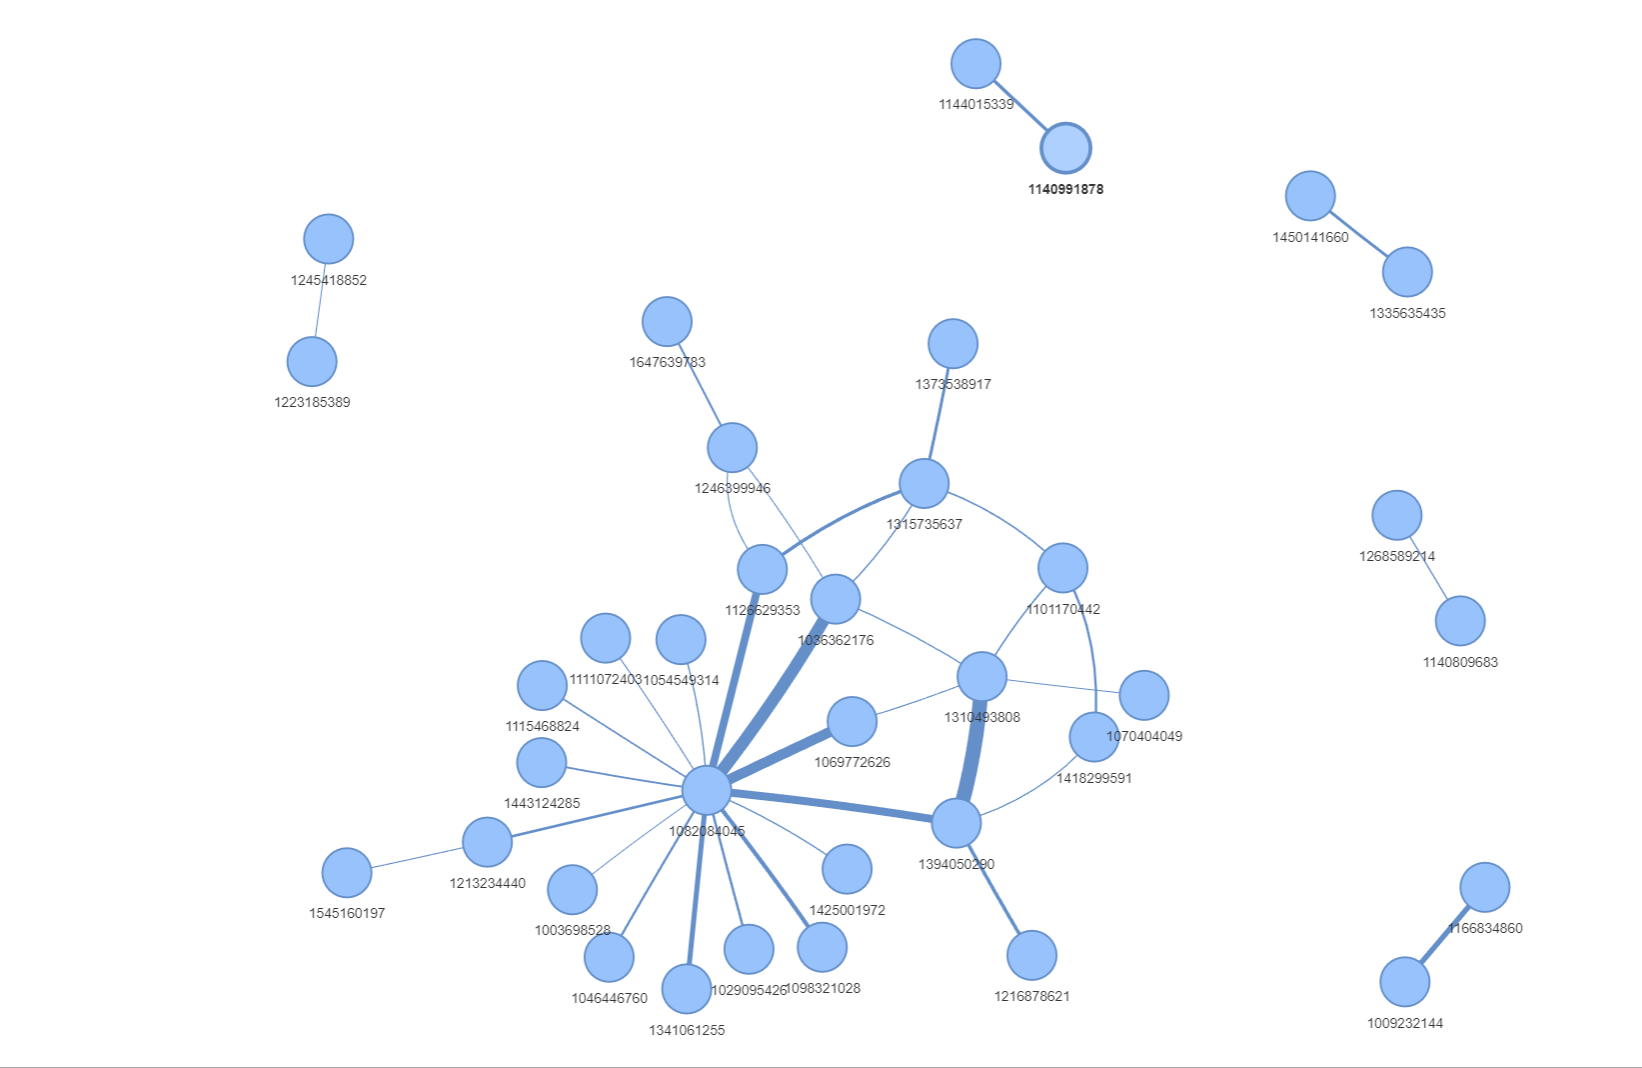

In [70]:
for row in pd_graph_100.itertuples():
    G.add_node(row.channel_id_to)
    G.add_node(row.channel_id_forward)
    G.add_edge(row.channel_id_to, row.channel_id_forward, weight=row.count)

net = Network(notebook=True, cdn_resources='remote') 

# Дадаємо вузли
for node in G.nodes:
    net.add_node(node, label=str(node))

# Додавання вузлів з шириною звязків між ними
for u, v in G.edges:
    weight = G[u][v]['weight']
    net.add_edge(u, v, value=weight)  
    
# net.show("channel_interactions.html", notebook=True)

# Display the image in the notebook (optional)
from IPython.display import Image
Image(filename="int.png")

*На отриманому графі товщина ліній між вузлами позначає кількість комунікацій, чим вона ширша, тим їх більше. 
Можна чітко виділити одну основну групу з номером 1082084045, яка має найбільше вхідних і вихідних комунікацій, 
це дає нам змогу припустити, що в цій групі найбільше користувачів і вона може бути найбільш популярною. Також є пятірка груп, які взаємодіють між собою, можливо ці групи 
публікують повідомлення з якоїсь специфічної теми, або ці групи є закритими. З графу видно, що є групи які також комунікують лише з однією групою, в той час як група з якою комунікують має звязки з іншими групами.*


*Спробуємо побудувати графік, щоб побачити, які групи мають найбільше вхідних комунікацій*

<IPython.core.display.Javascript object>


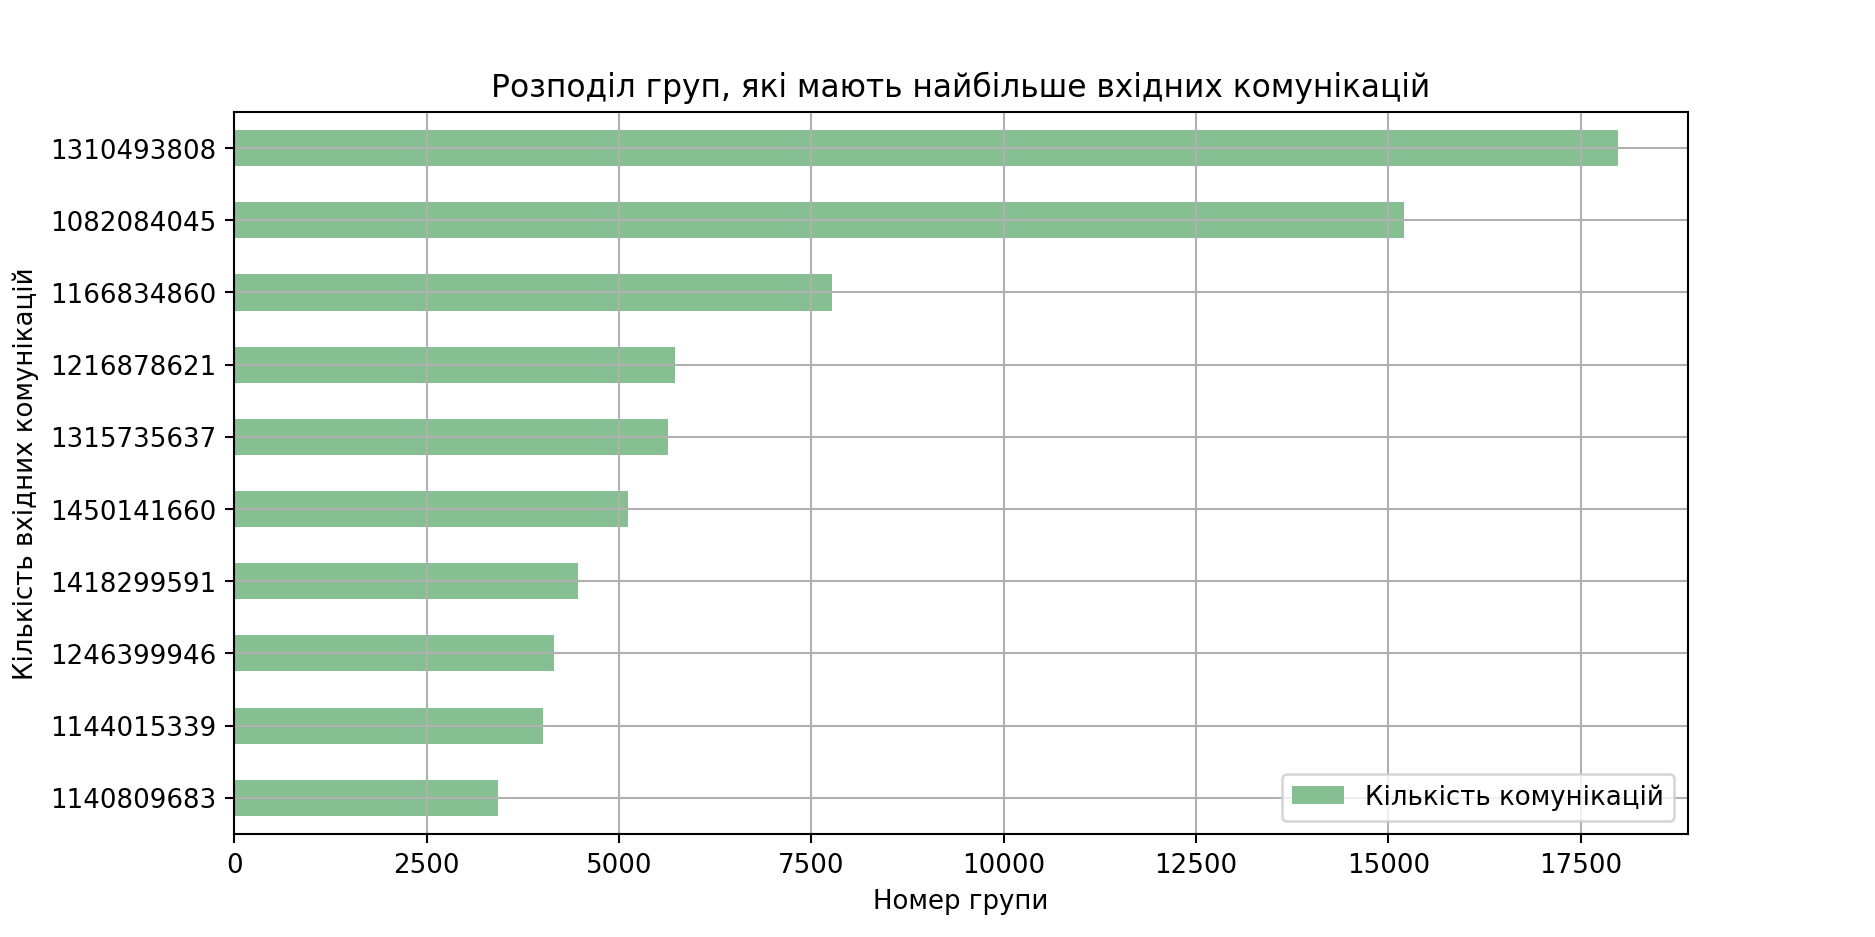

In [83]:
ggg = pd_graph_100.drop_duplicates(subset=['channel_id_to'])[:10]
ax = ggg.plot.barh(x='channel_id_to', y='count', figsize=(10, 5), color='#86bf91')
ax.invert_yaxis()
ax.legend(['Кількість комунікацій']);
plt.title('Розподіл груп, які мають найбільше вхідних комунікацій')
plt.xlabel('Номер групи')
plt.ylabel('Кількість вхідних комунікацій')
plt.grid(True)
plt.show()

*Тепер давайте побудуємо графік, щоб виявити, які групи мають найбільше вихідних комунікацій.*

<IPython.core.display.Javascript object>


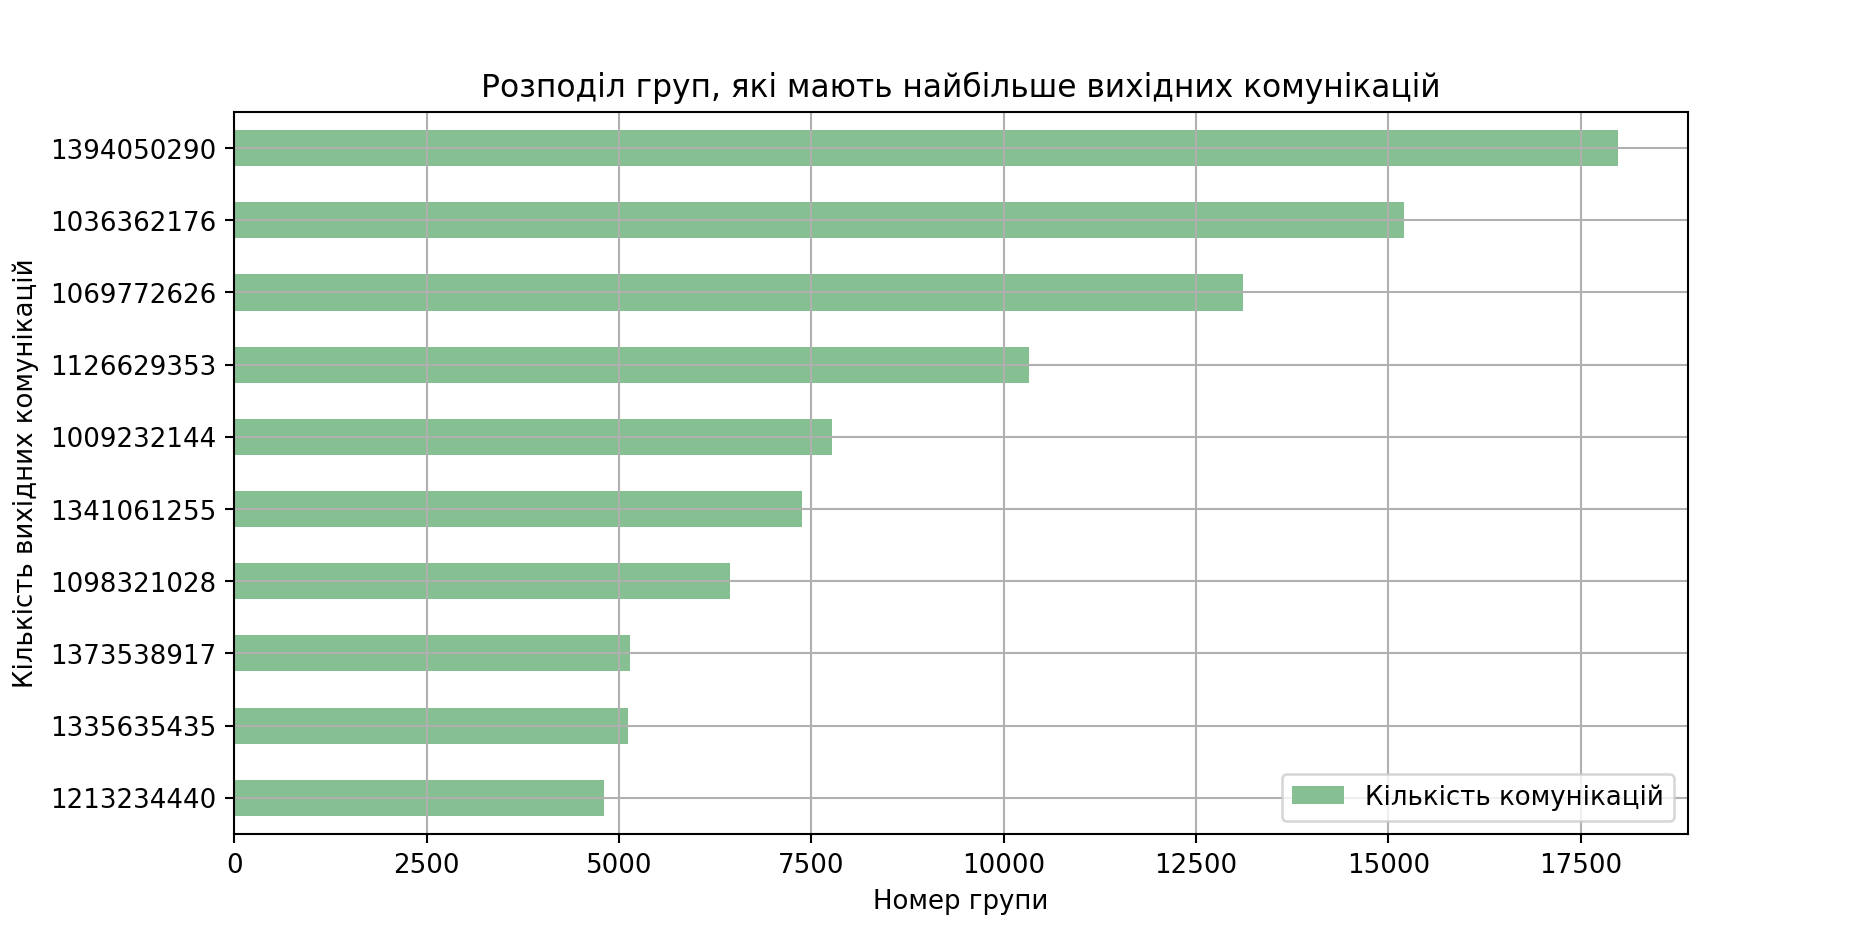

In [84]:
gggg = pd_graph_100.drop_duplicates(subset=['channel_id_forward'])[:10]
ax = gggg.plot.barh(x='channel_id_forward', y='count', figsize=(10, 5), color='#86bf91')
ax.invert_yaxis()
ax.legend(['Кількість комунікацій']);
plt.title('Розподіл груп, які мають найбільше вихідних комунікацій')
plt.xlabel('Номер групи')
plt.ylabel('Кількість вихідних комунікацій')
plt.grid(True)
plt.show()

*Аналіз отриманих графіків, вказує на те, що групи з найбільшою кількістю вхідних та вихідних комунікацій є різними. Тобто групи, які
мають найбільше вхідних комунікацій не мають багато вихідних комунікацій і навпаки.*

*Для подальшої роботи з даними здійснимо їх попередню обробку*

In [5]:
# Видалення непотрібних колонок
df = df.drop('Unnamed: 0', ' fwd_from', 'duration', 'frw_from_title', 'frw_from_name', 'msg_entity', '_c0', 'id')

*Нижче ми бачимо, що є колонки рядки яких мають не правильні записи, тобто замість чисел там слова, давайте видалимо їх.*

In [6]:
# Перетворення колонки 'date' в тип дати, враховуючи, що вона має правильний формат
df_22 = df.withColumn("date", col("date").cast(DateType()))

# Відфільтрувати рядки, в яких 'date' не є датою
invalid_date_rows = df_22.filter(col("date").isNull())
invalid_date_rows.show(5)

+----+--------------------+--------------------+-----+--------+-------+----+
|date|               views|           reactions|to_id|fwd_from|message|type|
+----+--------------------+--------------------+-----+--------+-------+----+
|NULL| представляющим у...|  так и для Китая»."|photo|    NULL|   NULL|NULL|
|NULL| - говорит торгов...| перелёты из Маха...|photo|    NULL|   NULL|NULL|
|NULL| бутафорскими сле...|               video| 12.0|    NULL|   NULL|NULL|
|NULL|                NULL|                NULL| NULL|    NULL|   NULL|NULL|
|NULL|                NULL|                NULL| NULL|    NULL|   NULL|NULL|
+----+--------------------+--------------------+-----+--------+-------+----+
only showing top 5 rows



In [7]:
df = df.filter(col("date").rlike("^\\d{4}-\\d{2}-\\d{2} \\d{2}:\\d{2}:\\d{2}.*$"))
print('Shape:', df.count(), len(df.columns))

Shape: 8108321 7


In [8]:
# Додамо колонку з індексом
df = df.withColumn("index", monotonically_increasing_id()).select("index", *df.columns)

In [9]:
df.show(5)

+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+
|index|                date| views|           reactions|               to_id|            fwd_from|             message| type|
+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+
|    0|2022-12-19 13:05:...|3645.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇵🇰🇦🇫 Исламаба...|photo|
|    1|2022-12-19 09:52:...|5831.0|MessageReactions(...|PeerChannel(chann...|                NULL|🕯️ 6 лет назад, ...|photo|
|    2|2022-12-19 09:18:...|3944.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇮🇷🇷🇺 Глава МИ...|photo|
|    3|2022-12-19 08:32:...|2970.0|MessageReactions(...|PeerChannel(chann...|MessageFwdHeader(...|Наши Друзья откры...|photo|
|    4|2022-12-18 21:41:...|4993.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇷🇺 Сегодня, 19 ...|photo|
+--

In [10]:
# Перетворимо колонку date з формату string в формат date
df = df.withColumn("formatted_date", date_format(to_date(col("date"), "yyyy-MM-dd HH:mm:ssXXX"), "yyyy-MM-dd")).drop("date")

In [11]:
df.show(5)

+-----+------+--------------------+--------------------+--------------------+--------------------+-----+--------------+
|index| views|           reactions|               to_id|            fwd_from|             message| type|formatted_date|
+-----+------+--------------------+--------------------+--------------------+--------------------+-----+--------------+
|    0|3645.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇵🇰🇦🇫 Исламаба...|photo|    2022-12-19|
|    1|5831.0|MessageReactions(...|PeerChannel(chann...|                NULL|🕯️ 6 лет назад, ...|photo|    2022-12-19|
|    2|3944.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇮🇷🇷🇺 Глава МИ...|photo|    2022-12-19|
|    3|2970.0|MessageReactions(...|PeerChannel(chann...|MessageFwdHeader(...|Наши Друзья откры...|photo|    2022-12-19|
|    4|4993.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇷🇺 Сегодня, 19 ...|photo|    2022-12-18|
+-----+------+--------------------+----------------

In [12]:
df = df.select("index", "formatted_date", *df.columns[1:-1])

In [13]:
df.show(5)

+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+
|index|formatted_date| views|           reactions|               to_id|            fwd_from|             message| type|
+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+
|    0|    2022-12-19|3645.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇵🇰🇦🇫 Исламаба...|photo|
|    1|    2022-12-19|5831.0|MessageReactions(...|PeerChannel(chann...|                NULL|🕯️ 6 лет назад, ...|photo|
|    2|    2022-12-19|3944.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇮🇷🇷🇺 Глава МИ...|photo|
|    3|    2022-12-19|2970.0|MessageReactions(...|PeerChannel(chann...|MessageFwdHeader(...|Наши Друзья откры...|photo|
|    4|    2022-12-18|4993.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇷🇺 Сегодня, 19 ...|photo|
+-----+--------------+------+--------------------+-

*Створимо колонку з хештегами для подальшого аналізу*

In [14]:
def extract_hashtags(text):
    import re
    return re.findall(r"#\w+", text) if text else []

extract_hashtags_udf = udf(extract_hashtags, ArrayType(StringType()))

# Застосовуємо UDF до стовпця "message" в DataFrame
df = df.withColumn("hashtags", extract_hashtags_udf(when(col("message").isNotNull(), col("message"))))

In [15]:
df.show(5)

+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+
|index|formatted_date| views|           reactions|               to_id|            fwd_from|             message| type|hashtags|
+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+
|    0|    2022-12-19|3645.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇵🇰🇦🇫 Исламаба...|photo|      []|
|    1|    2022-12-19|5831.0|MessageReactions(...|PeerChannel(chann...|                NULL|🕯️ 6 лет назад, ...|photo|      []|
|    2|    2022-12-19|3944.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇮🇷🇷🇺 Глава МИ...|photo|      []|
|    3|    2022-12-19|2970.0|MessageReactions(...|PeerChannel(chann...|MessageFwdHeader(...|Наши Друзья откры...|photo|      []|
|    4|    2022-12-18|4993.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇷🇺 Сегодня, 19

*Зробимо попередній препроцесінг текстових даних*

In [16]:
# Токенізуємо слова і видалимо стопслова з датасету
tokenizer = RegexTokenizer(inputCol="message", outputCol="words", pattern="[\\s,.;!?]+", minTokenLength=1)
tokenized_df = tokenizer.transform(df)

In [17]:
tokenized_df.show(5)

+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+
|index|formatted_date| views|           reactions|               to_id|            fwd_from|             message| type|hashtags|               words|
+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+
|    0|    2022-12-19|3645.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇵🇰🇦🇫 Исламаба...|photo|      []|[🇵🇰🇦🇫, ислама...|
|    1|    2022-12-19|5831.0|MessageReactions(...|PeerChannel(chann...|                NULL|🕯️ 6 лет назад, ...|photo|      []|[🕯️, 6, лет, наз...|
|    2|    2022-12-19|3944.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇮🇷🇷🇺 Глава МИ...|photo|      []|[🇮🇷🇷🇺, глава,...|
|    3|    2022-12-19|2970.0|MessageReactions(...|PeerChannel(chann...|MessageFwdHeader(...|Наши Друзья откры...|photo

In [18]:
stop_words = [
    "и", "в", "во", "не", "что", "он", "на", "я", "с", "со", "как", "а", "то",
    "все", "она", "так", "его", "но", "да", "ты", "к", "у", "же", "вы", "за",
    "бы", "по", "только", "ее", "мне", "было", "вот", "от", "меня", "еще", "нет",
    "о", "из", "ему", "теперь", "когда", "даже", "ну", "вдруг", "ли", "если", "уже",
    "или", "ни", "быть", "был", "него", "до", "вас", "нибудь", "опять", "уж", "вам",
    "ведь", "там", "потом", "себя", "ничего", "ей", "может", "они", "тут", "где", "есть",
    "надо", "ней", "для", "мы", "тебя", "их", "чем", "была", "сам", "чтоб", "без", "будто",
    "чего", "раз", "тоже", "себе", "под", "будет", "ж", "тогда", "кто", "этот", "того",
    "потому", "этого", "какой", "совсем", "ним", "здесь", "этом", "один", "почти",
    "мой", "тем", "чтобы", "нее", "сейчас", "были", "куда", "зачем", "всех", "никогда",
    "можно", "при", "наконец", "два", "об", "другой", "хоть", "после", "над", "больше",
    "тот", "через", "эти", "нас", "про", "всего", "них", "какая", "много", "разве", "три",
    "эту", "моя", "впрочем", "хорошо", "свою", "этой", "перед", "иногда", "лучше", "чуть",
    "том", "нельзя", "такой", "им", "более", "всегда", "конечно", "всю", "между", 'RU'
]

In [19]:
# Створимо StopWordsRemover для видалення стоп слів
stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stop_words)
# Remove stop words
filtered_df = stop_words_remover.transform(tokenized_df).drop('words')

In [20]:
filtered_df.show(5)

+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+
|index|formatted_date| views|           reactions|               to_id|            fwd_from|             message| type|hashtags|      filtered_words|
+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+
|    0|    2022-12-19|3645.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇵🇰🇦🇫 Исламаба...|photo|      []|[🇵🇰🇦🇫, ислама...|
|    1|    2022-12-19|5831.0|MessageReactions(...|PeerChannel(chann...|                NULL|🕯️ 6 лет назад, ...|photo|      []|[🕯️, 6, лет, наз...|
|    2|    2022-12-19|3944.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇮🇷🇷🇺 Глава МИ...|photo|      []|[🇮🇷🇷🇺, глава,...|
|    3|    2022-12-19|2970.0|MessageReactions(...|PeerChannel(chann...|MessageFwdHeader(...|Наши Друзья откры...|photo

In [21]:
# Витягнемо year і month з колонки "date" 
filtered_df = filtered_df.withColumn("year", year(col("formatted_date")))
filtered_df = filtered_df.withColumn("month", month(col("formatted_date")))
filtered_df.show(5)

+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+----+-----+
|index|formatted_date| views|           reactions|               to_id|            fwd_from|             message| type|hashtags|      filtered_words|year|month|
+-----+--------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------+--------------------+----+-----+
|    0|    2022-12-19|3645.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇵🇰🇦🇫 Исламаба...|photo|      []|[🇵🇰🇦🇫, ислама...|2022|   12|
|    1|    2022-12-19|5831.0|MessageReactions(...|PeerChannel(chann...|                NULL|🕯️ 6 лет назад, ...|photo|      []|[🕯️, 6, лет, наз...|2022|   12|
|    2|    2022-12-19|3944.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇮🇷🇷🇺 Глава МИ...|photo|      []|[🇮🇷🇷🇺, глава,...|2022|   12|
|    3|    2022-12-19|2970.0|MessageReactions(...|Pe

#### Здіснимо загальне дослідження кількості постів в телеграм каналах, давши відповідь на наступні запитання:
1. Який розподіл кількості постів в залежності від року?
2. Який розподів постів по місяцям з початком повномасштабного вторгнення?

*Згрупуємо дані за роком і місяцем і порахуємо кількість постів*

In [107]:
result = filtered_df.groupBy("year", "month").count().orderBy("year", "month")

In [108]:
result.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2015|    9|   80|
|2015|   10|  501|
|2015|   11| 2137|
|2015|   12| 2337|
|2016|    1| 1527|
|2016|    2| 2075|
|2016|    3| 2106|
|2016|    4| 4093|
|2016|    5| 4488|
|2016|    6| 6144|
|2016|    7|10401|
|2016|    8|10838|
|2016|    9|12144|
|2016|   10|13537|
|2016|   11|13578|
|2016|   12|12853|
|2017|    1|15381|
|2017|    2|18437|
|2017|    3|24982|
|2017|    4|26871|
+----+-----+-----+
only showing top 20 rows



In [151]:
print('Shape:', result.count(), len(result.columns))

Shape: 88 3


*Як ми бачимо у нас є дані по кількості постів за 88 місяців починаючи з вересня 2015 року. Однак, для більшої репрезантативності даних залишимо роки в яких є всі 12 місяців, видаливши 9-10 місяці 2015 року.*

In [109]:
# Конвертуємо дані в Pandas DataFrame
result = result.toPandas()

In [110]:
result = result[result.year != 2015].dropna()

<IPython.core.display.Javascript object>


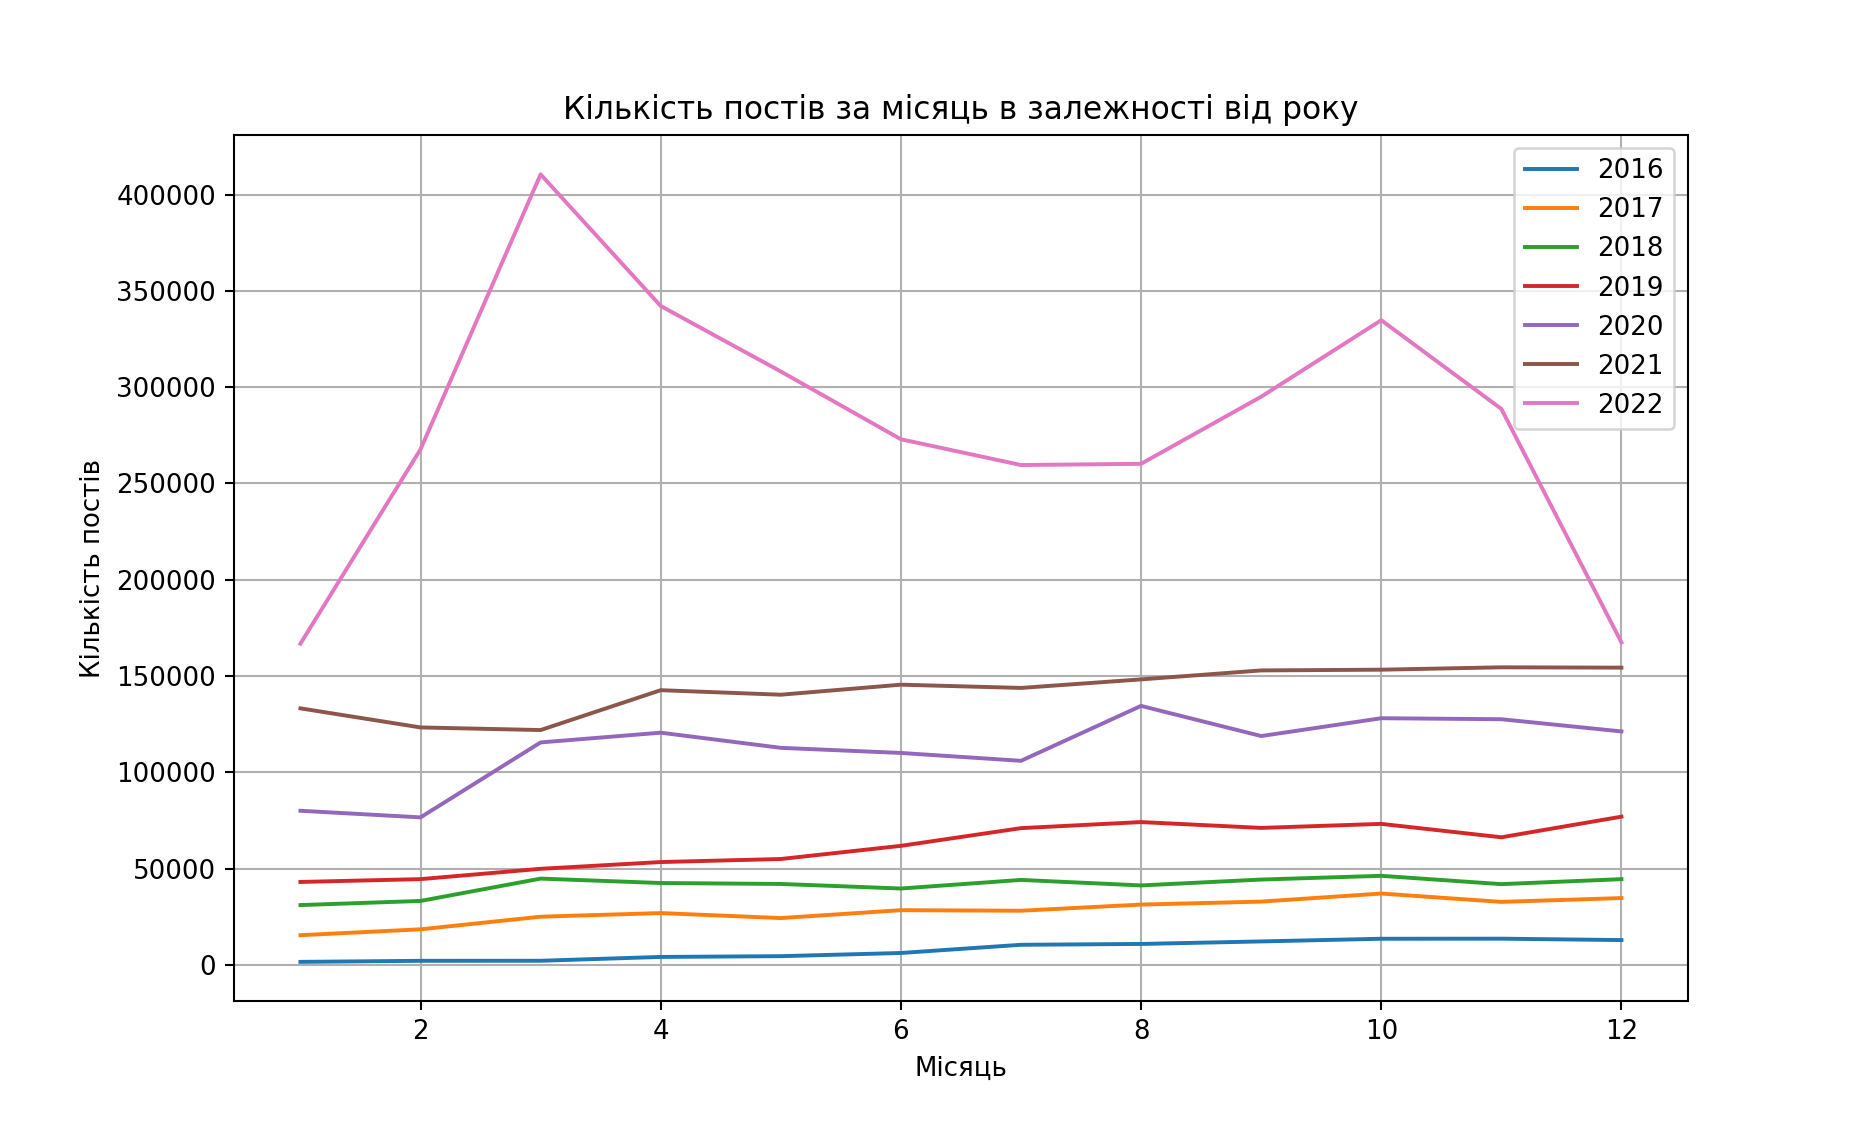

In [111]:
# Візуалізуємо часовий розподіл
plt.figure(figsize=(10, 6))
for year in result["year"].unique():
    data = result[result["year"] == year]
    plt.plot(data["month"], data["count"], label=f'{int(year)}')

plt.xlabel("Місяць")
plt.ylabel("Кількість постів")
plt.title("Кількість постів за місяць в залежності від року")
plt.legend()
plt.grid(True)
plt.show()



Як ми бачимо з кожним роком кількість постів збільшується, це може бути повязано з:
- підвищенням рівня життя населення і можливість купити собі смартфон;
- збільшення кількість груп в телеграмі;
- необхідністю збільшення кількості пропаганди для пришвидшення анексії окупованих територій;

Цікаво що в 2019 - 2021 роках, кількість постів збільшувалась приблизно на 50 000, що є достатньо суттєвим. 
З початком початком повномасштабного вторгнення кількість постів порявняно з 2016 років зросла приблизно на 350 000. 
Спробуємо відобразити наші дані у вигляді бар-плоту.

In [112]:
grouped_data = result.groupby(["year", "month"])["count"].sum().unstack()

In [113]:
grouped_data.index = grouped_data.index.astype(int)
grouped_data.columns = grouped_data.columns.astype(int)

<IPython.core.display.Javascript object>


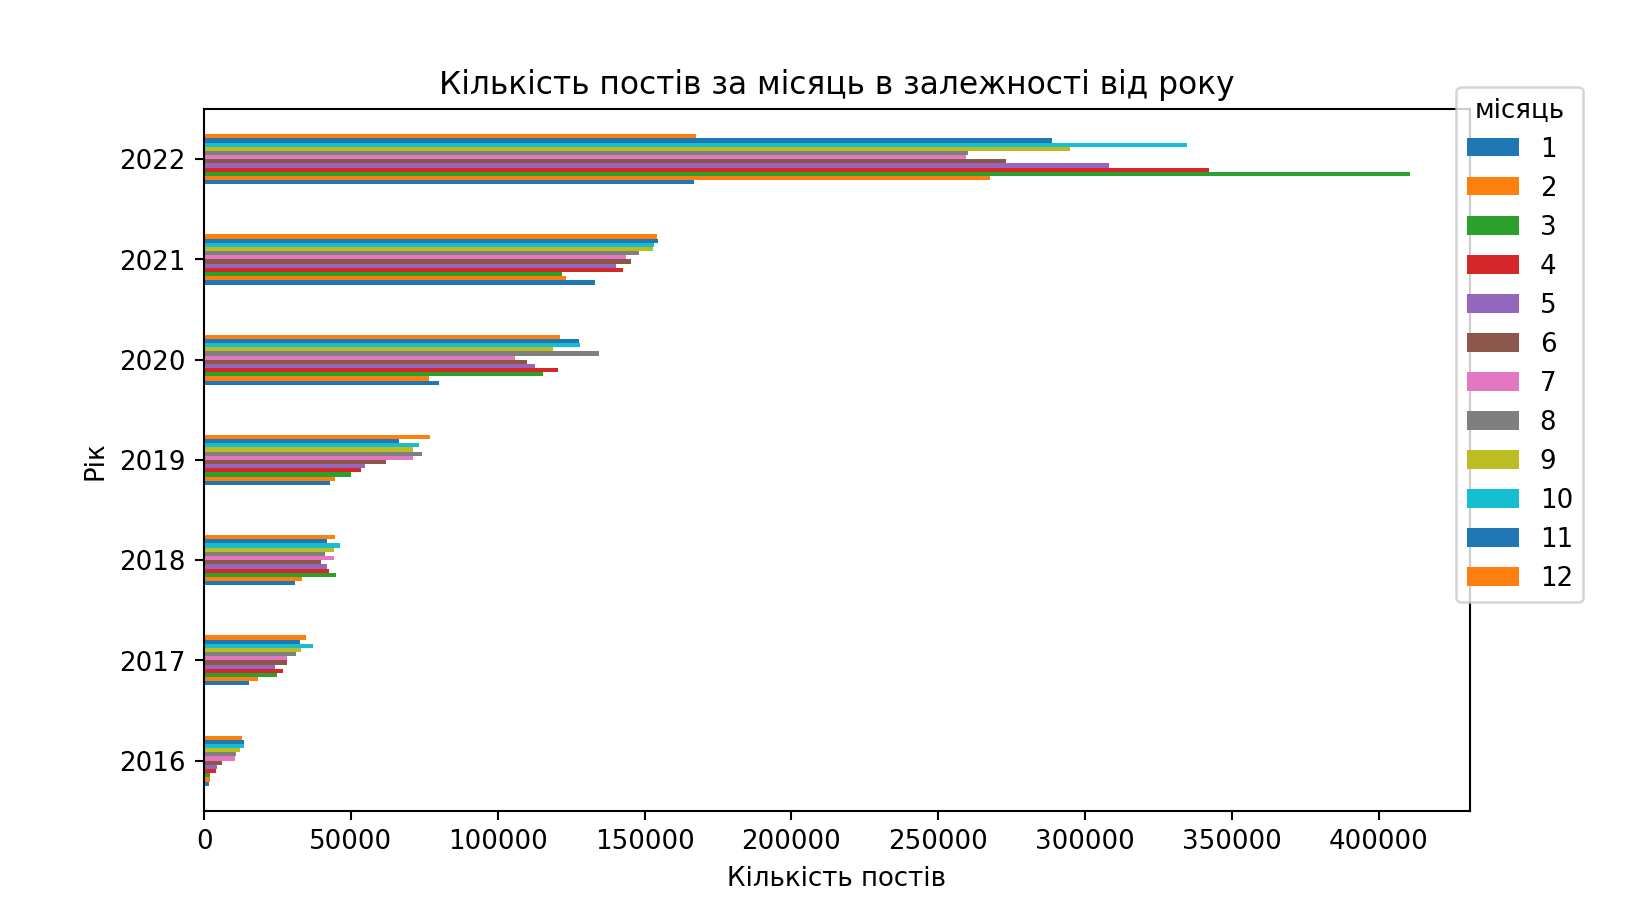

In [114]:
grouped_data.plot.barh() 
plt.xlabel("Кількість постів")
plt.ylabel("Рік")
plt.title("Кількість постів за місяць в залежності від року")
plt.legend(bbox_to_anchor=(1.1, 1.05), title='місяць')
plt.show()

*Ці графіки по різному відображають розподіл даних, однак особисто для мене вони обидна є інформативними і показують однакові результати.*

*Давайте спробуємо більш детально глянути на графік розподілу постів по місяцях з початком війни у лютому 2022 року.*

In [115]:
result.year = result.year.astype(int)
result.month = result.month.astype(int)
result_2022 = result[result['year'] == 2022]
result_2022

year  month   count
76  2022      1  166792
77  2022      2  267712
78  2022      3  410514
79  2022      4  342162
80  2022      5  308140
81  2022      6  272952
82  2022      7  259561
83  2022      8  260198
84  2022      9  295044
85  2022     10  334776
86  2022     11  288703
87  2022     12  167427

<IPython.core.display.Javascript object>


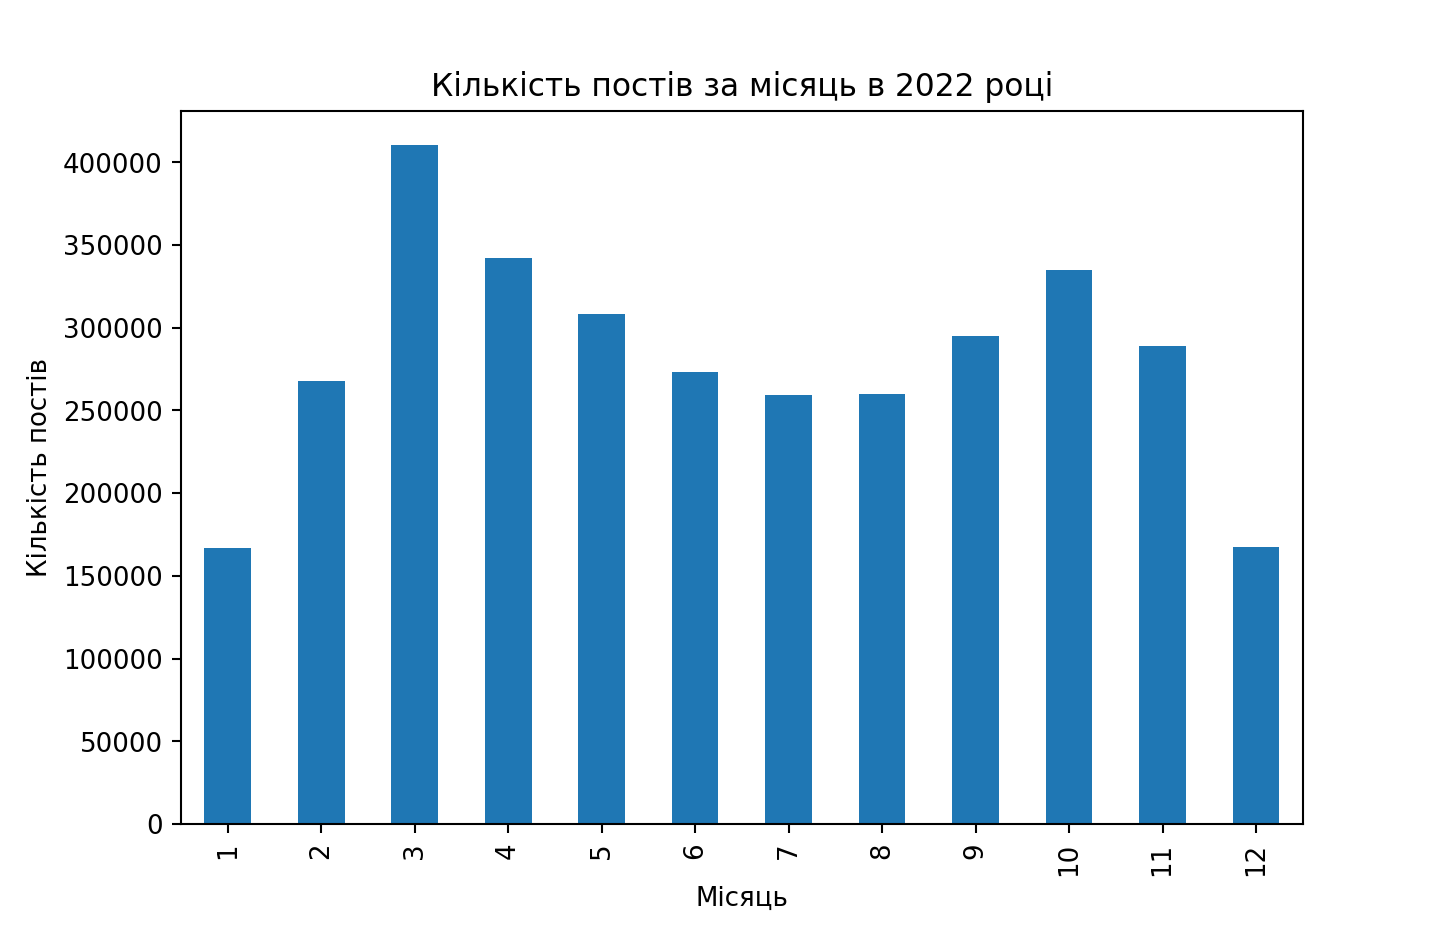

In [116]:
ax = result_2022.plot.bar(x="month", y = "count") 
plt.xlabel('Місяць')
plt.ylabel("Кількість постів")
plt.title("Кількість постів за місяць в 2022 році")
ax.get_legend().remove()
plt.show()

*Оскільки війна розпочалась у кінці лютого 2022 року, то зрозуміло що пік постів припав на берень місяць, оскільки на всіх рівнях
це була найбільш оброворювана новина. Далі по трохи кількість постів пішла на спад і наступний пік спостерігався у жовтні 2022 рокую
В цьому місяці був підірваний Керченський міст, тому цей пік може бути повязаний саме з цією новиною. Також саме на цей період припадає початок 
найбільших масованих обстрілів України для виведення з ладу критичної інфраструктури.*

*Давайте перейдемо до аналізу хештегів*

Для початку дамо відповіді на наступні запитання:
1. В якому місяці та році було найбільше постів з хештегами, які відносяться до країн НАТО, США або ЄС?
2. В якому році було найбільше постів з хештегами, які відносяться до країн НАТО, США або ЄС?

In [22]:
# Визначимо UDF для трансформації слів в нижній реєстр
def lowercase_array(arr):
    return [element.lower() for element in arr]

lowercase_array_udf = udf(lowercase_array, ArrayType(StringType()))

# Визначи UDF для створення нової колонки з хештегами нижнього регістру
df_find_hash = filtered_df.withColumn("lowercase_hash", lowercase_array_udf(col('hashtags')))


In [23]:
hashtags_to_find = ["#сша", 
                    "#нато", 
                    "#eu", 
                    '#us', 
                    '#usa', 
                    '#nato',
                    "#австрия",
                    "оон",
    "#албания",
    "#андорра",
    "#бельгия",
    "#болгария",
    "#ватикан",
    "#великобритания",
    "#венгрия",
    "#германия",
    "#греция",
    "#дания",
    "#ирландия",
    "#исландия",
    "#испания",
    "#италия",
    "#кипр",
    "#латвия",
    "#литва",
    "#лихтенштейн",
    "#люксембург",
    "#македония",
    "#мальта",
    "#молдавия",
    "#монако",
    "#нидерланды",
    "#норвегия",
    "#польша",
    "#португалия",
    "#румыния",
    "#сан-марино",
    "#сербия",
    "#словакия",
    "#словения",
    "#финляндия",
    "#франция",
    "#хорватия",
    "#черногория",
    "#чехия",
    "#швейцария",
    "#швеция",
    "#эстония"
                   ]


In [24]:
# Визначимо функцію для рахування кількості появи хештегів в списку
def count_hashtags(hashtags_list):
    count = 0
    for hashtag in hashtags_to_find:
        if hashtag in hashtags_list:
            count += 1
    return count

count_hashtags_udf = udf(count_hashtags, IntegerType())

# Створимо нову колонку з кількістю хештегів
df_find_hash = df_find_hash.withColumn("count_of_hashtags", count_hashtags_udf(col("lowercase_hash")))


In [120]:
# Групуємо дані за роком та місяцем та рахуємо кількість постів
result_hash = df_find_hash.groupBy("year", "month").agg({"count_of_hashtags": "sum"}).orderBy("year", "month")

In [121]:
result_hash = result_hash.toPandas()

In [122]:
result_hash = result_hash[result_hash.year != 2015].dropna()
result_hash.year, result_hash.month = result_hash.year.astype(int), result_hash.month.astype(int)

In [123]:
result_hash.head()

year  month  sum(count_of_hashtags)
4  2016      1                       3
5  2016      2                       0
6  2016      3                       0
7  2016      4                       0
8  2016      5                       0

<IPython.core.display.Javascript object>


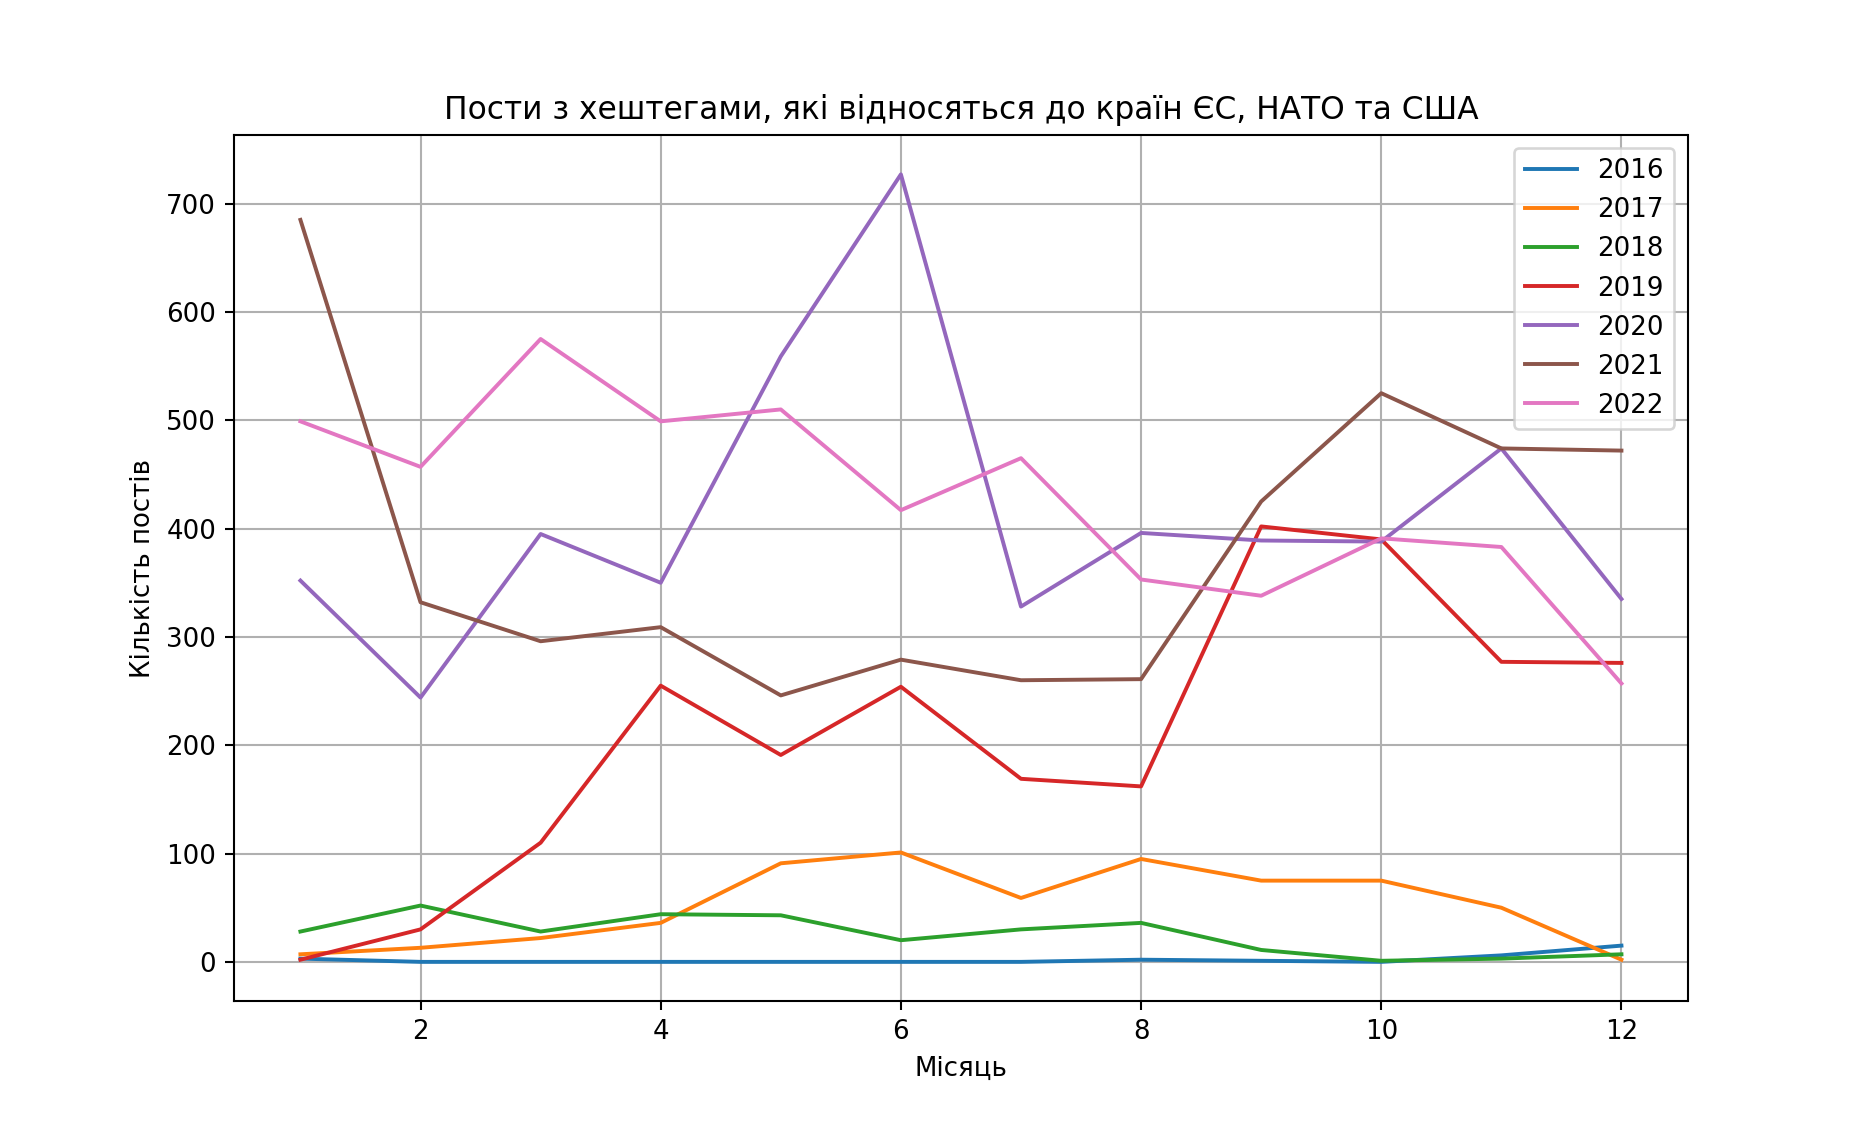

In [125]:
plt.figure(figsize=(10, 6))
for year in result_hash["year"].unique():
    data = result_hash[result_hash["year"] == year]
    plt.plot(data["month"], data["sum(count_of_hashtags)"], label=f'{year}')

plt.xlabel("Місяць")
plt.ylabel("Кількість постів")
plt.title("Пости з хештегами, які відносяться до країн ЄС, НАТО та США")
plt.legend()
plt.grid(True)
plt.show()


*Як ми бачимо розподіл кількості постів в часовому графіку розподілу є незручною і тяжкою для аналізу. Однак, ми маємо один чіткий 
пік у червні 2020 року. Можна зробити припущення, що він повязаний з виборами президента Польщі, оскільки Польща є одним з найближчих
союзників України. Саме в цей час відбувались протести проти расизму та поліцейської насильницької в Європі. Також, саме в цьому місяці Україна стала членом Програми розширених можливостей НАТО*

*Давайте розглянемо розподіл кількості таких постів в залежності від року.*

In [126]:
hist_plot = result_hash.groupby('year').agg({"sum(count_of_hashtags)":"sum"})

<IPython.core.display.Javascript object>


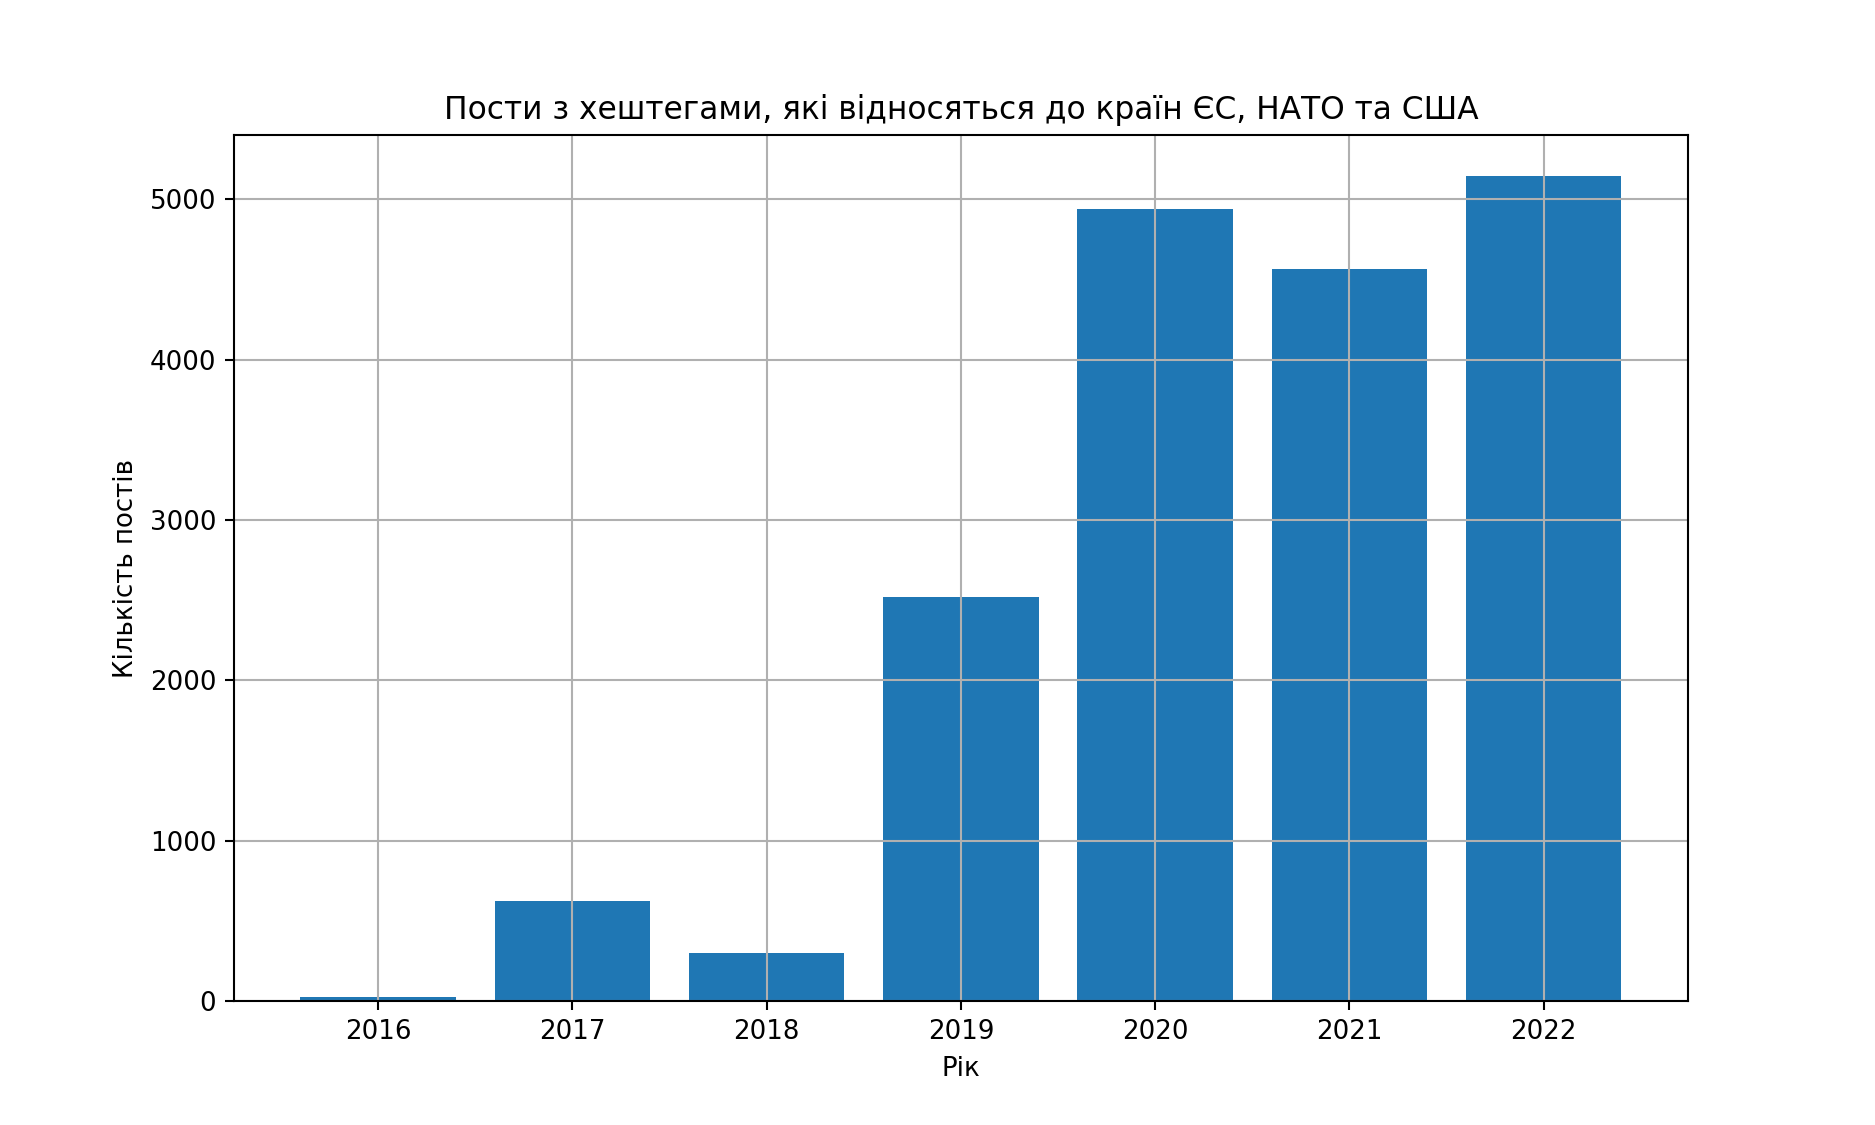

In [127]:
plt.figure(figsize=(10, 6))
plt.bar(hist_plot.index, hist_plot['sum(count_of_hashtags)'])
plt.xlabel("Рік")
plt.ylabel("Кількість постів")
plt.title("Пости з хештегами, які відносяться до країн ЄС, НАТО та США")
plt.grid(True)
plt.show()

*Такий графік є легшим для аналізу. Тут ми бачимо що кількість постів з хештегами, які відносяться до Європи зросла починаючи з 2019 року.
Якщо ми візьмемо до уваги попередні висновки, що починаючи саме з 2019 року зросла і загальна кількість постів, то можна зробити висновок,
що російська пропаганда почала дуже активно працювати та можливо готовити народ своєї країни до вторгнення в Україну. Тобто 
десь приблизно 3 роки вони активно пропагували погане життя в Європі, щоб в подальшому виправдати своє вторгнення до України.*

Давайте тепер проаналізуємо кількість постів з хештегами, які мають відношення до України, а саме дамо відповідь на запитання:
1. В якому місяці та році було найбільше постів з хештегами, які відносяться до України?
2. В якому році було найбільше постів з хештегами, які відносяться до України?

In [128]:
hashtags_to_find = ["#украина", 
    "#винница",
    "#львов",
    "#днепр",
    "#донецк",
    "#житомир",
    "#ужгород",
    "#запорожье",
    "#ивано-франковск",
    "#кропивницкий",
    "#киев",
    "#луганск",
    "#львов",
    "#николаев",
    "#одесса",
    "#полтава",
    "#ровно",
    "#сумы",
    "#тернополь",
    "#харьков",
    "#херсон",
    "#хмельницкий",
    "#черкассы",
    "#черновцы",
    "#чернигов",
    "#симферополь",
    "#киев",
    "#севастополь",
    "донбасс"
]

In [129]:
df_find_hash_ukr = df_find_hash.withColumn("count_of_hashtags_ukr", count_hashtags_udf(col("lowercase_hash")))

In [130]:
# Групуємо дані за роком та місяцем і рахуємо кількість постів
result_hash_ukr = df_find_hash_ukr.groupBy("year", "month").agg({"count_of_hashtags_ukr": "sum"}).orderBy("year", "month")

In [131]:
result_hash_ukr = result_hash_ukr.toPandas()

In [132]:
result_hash_ukr = result_hash_ukr[result_hash_ukr.year != 2015].dropna()

In [133]:
result_hash_ukr.head(3)

year  month  sum(count_of_hashtags_ukr)
4  2016      1                           3
5  2016      2                           0
6  2016      3                           0

<IPython.core.display.Javascript object>


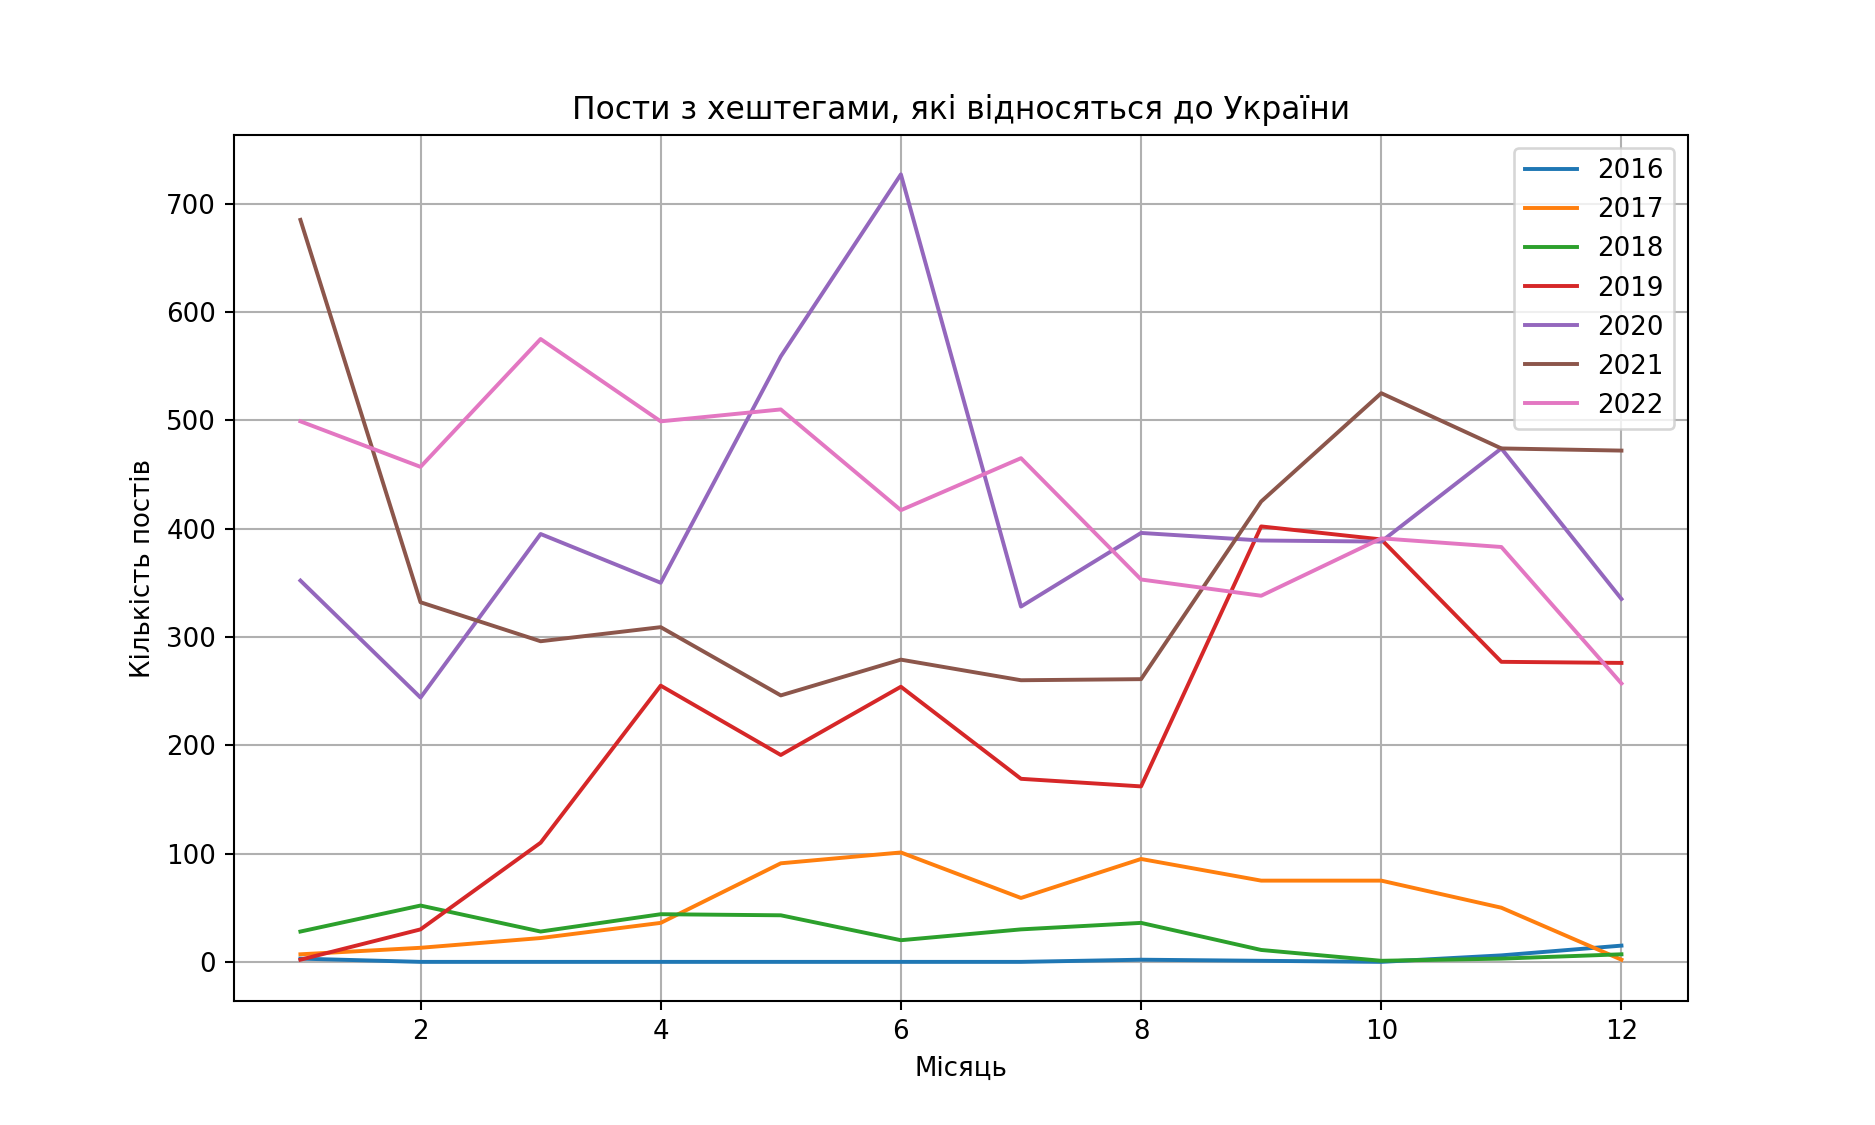

In [134]:
plt.figure(figsize=(10, 6))
for year in result_hash_ukr["year"].unique():
    data = result_hash_ukr[result_hash_ukr["year"] == year]
    plt.plot(data["month"], data["sum(count_of_hashtags_ukr)"], label=f'{year}')

plt.xlabel("Місяць")
plt.ylabel("Кількість постів")
plt.title("Пости з хештегами, які відносяться до України")
plt.legend()
plt.grid(True)
plt.show()

*Тут ми також бачимо пік у червні 2020 року, думаю це через попередню причину, а саме вибори в Польщі. Хоча особисто я очікувала
побачити пік у березні 2022 року.*

*Дослідимо розподіл цих постів по роках.*

In [138]:
hist_plot = result_hash_ukr.groupby('year').agg({"sum(count_of_hashtags_ukr)":"sum"})

<IPython.core.display.Javascript object>


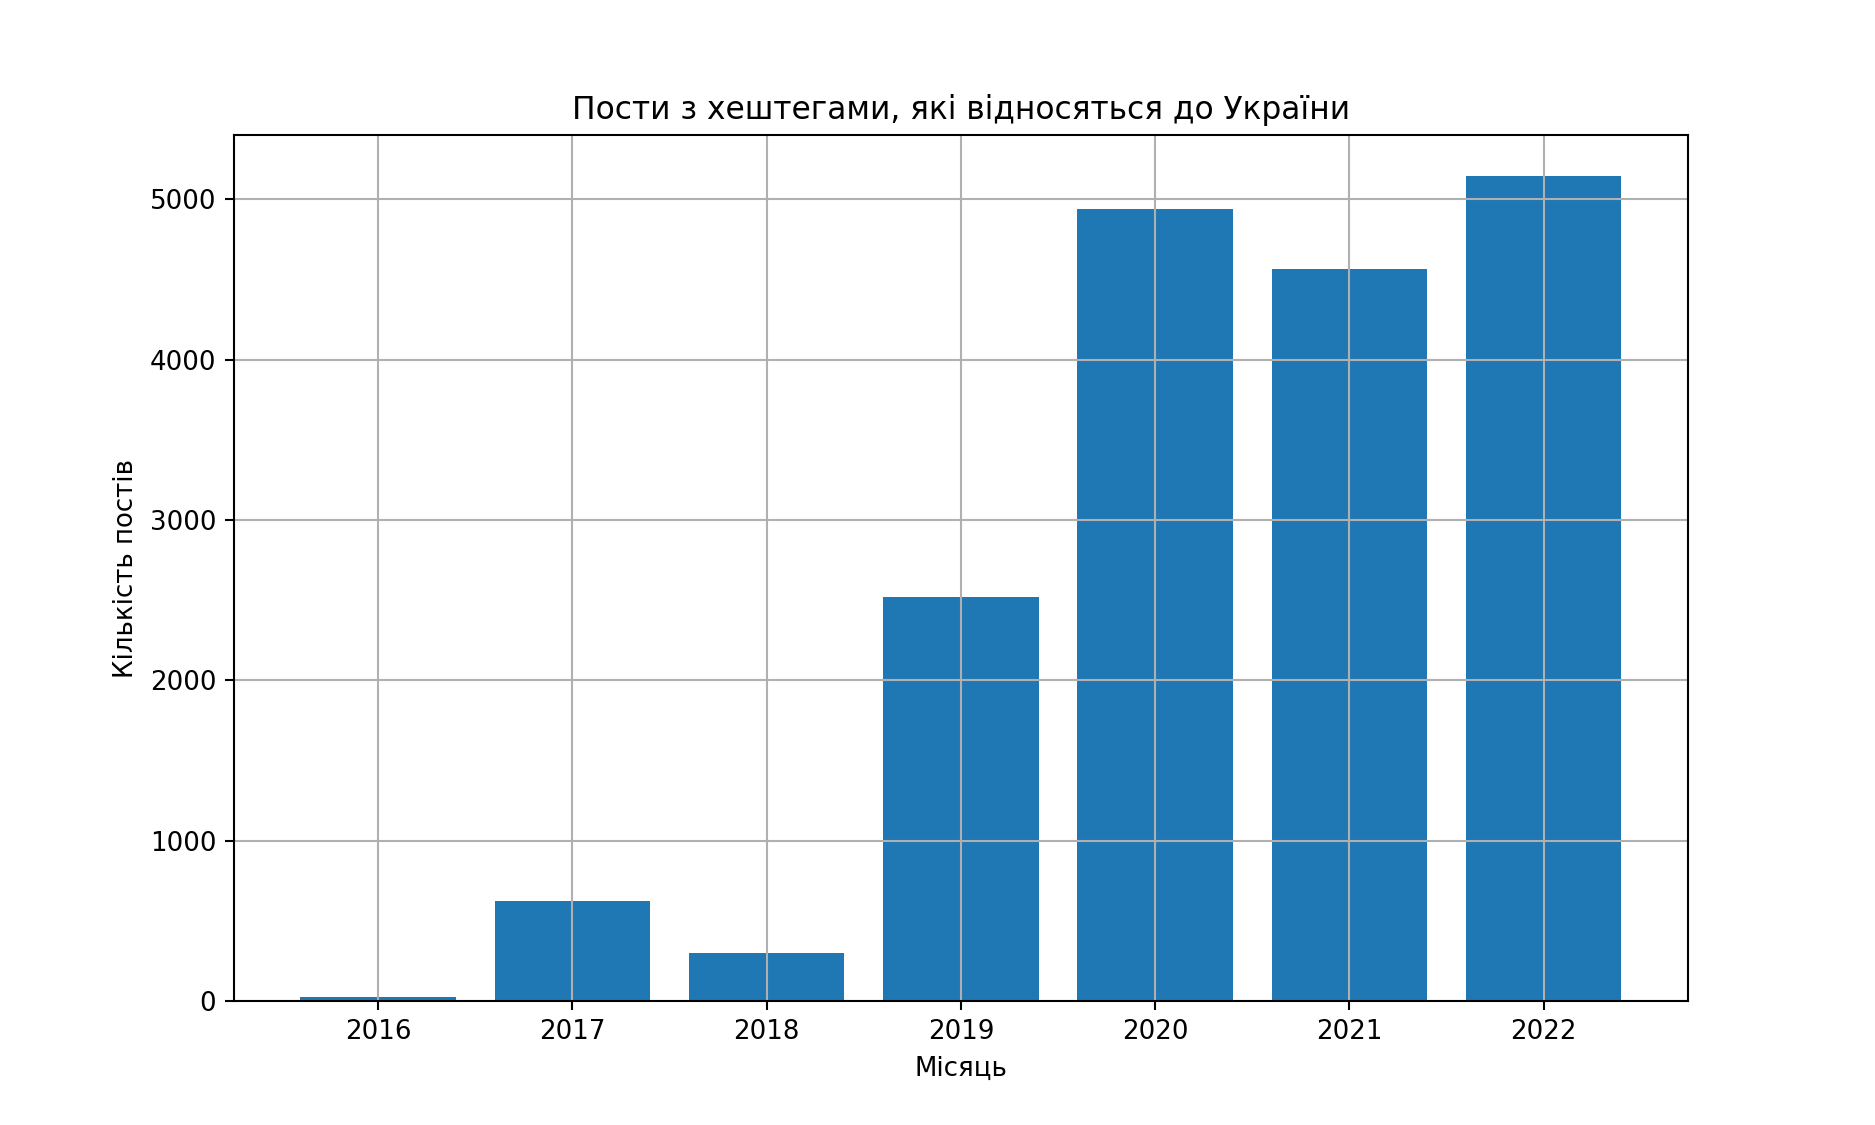

In [139]:
plt.figure(figsize=(10, 6))
plt.bar(hist_plot.index, hist_plot['sum(count_of_hashtags_ukr)'])
plt.xlabel("Місяць")
plt.ylabel("Кількість постів")
plt.title("Пости з хештегами, які відносяться до України")
plt.grid(True)
plt.show()

*Цей графік показує таку саму тенденцію, як і аналіз постів з хештегами, що відносяться до Європи. Кількість постів збільшилась з 
2019 року, тобто можна зробити висновки, що саме в 2019 році активізувалась сильна пропаганда.*

Не знаю наскільки це може бути інформативно, але давайте спробуємо дати відповідь на запитання:
1. Які переглянути пости отримали найбільше переглядів користувачів.

In [140]:
# Групуємо за місяцем та роком, щоб знайти максимальне значення переглядів у кожному році та місяці
max_views = filtered_df.groupBy("year", "month").agg(max("views").alias("max_views"))

In [141]:
max_views.show()

+----+-----+---------+
|year|month|max_views|
+----+-----+---------+
|2015|    9|    355.0|
|2015|   10|    517.0|
|2015|   11|     99.0|
|2015|   12|    545.0|
|2016|    1|    563.0|
|2016|    2|    981.0|
|2016|    3|    972.0|
|2016|    4|   9681.0|
|2016|    5|    995.0|
|2016|    6|    996.0|
|2016|    7|    999.0|
|2016|    8|   9993.0|
|2016|    9|    999.0|
|2016|   10|    998.0|
|2016|   11|    999.0|
|2016|   12|    998.0|
|2017|    1|    999.0|
|2017|    2|    999.0|
|2017|    3|    999.0|
|2017|    4|    999.0|
+----+-----+---------+
only showing top 20 rows



In [142]:
max_views_filtered = max_views.withColumnRenamed("max_views", "views")

In [143]:
filtered_df_filtered = filtered_df.select("year", "month", "views", 'message')
k = max_views_filtered.join(filtered_df_filtered, ["year", "month", 'views'], "inner")

In [144]:
max_view_pd = k.toPandas()

In [145]:
filtered_data = max_view_pd[max_view_pd['year']==2015][['month','views','message']].sort_values(by='month')


In [146]:
from prettytable import PrettyTable

# Створюємо обєкт PrettyTable і визначаємо імена колонок
table = PrettyTable()
table.field_names = ['month','views','message']
table.title = "Most Viewed Messages in different monthes in 2015"
# Додаємо дані до таблиці
for index, row in filtered_data.iterrows():
    table.add_row([row['month'], row['views'], row['message']])

print(table)

+--------------------------------------------------------------------------------------------------------+
|                           Most Viewed Messages in different monthes in 2015                            |
+-------+-------+----------------------------------------------------------------------------------------+
| month | views |                                        message                                         |
+-------+-------+----------------------------------------------------------------------------------------+
|   9   | 355.0 |              Тестирую какую-то новую приблуду телеграма- публичные чатики              |
|   10  | 517.0 |             В России вступили в силу новые требования к местам для курения             |
|       |       |                             http://izvestia.ru/news/593161                             |
|   11  |  99.0 |                 Блаттер: «Я должен был уйти после мундиаля в Бразилии»                 |
|       |       |                    

*Як можна побачити ми маємо однакову кількість переглядів для різних постів, тому доцільно переглянути пости
з найбільшим переглядом відповідно до року.*

In [147]:
max_view_pd['views'] = max_view_pd['views'].astype(float)

# Видаляємо пусті значення
max_view_pd = max_view_pd.dropna(subset=['message'])


# Шукаємо рядок з постом з найбільшою кількістю переглядів кожного року
result = max_view_pd.groupby('year').apply(lambda x: x.loc[x['views'].idxmax()]).reset_index(drop=True)


In [148]:
from IPython.display import display

table = PrettyTable()
table.field_names = ['year', 'views', 'message']
table.title = "Most Viewed Messages in different years"

for index, row in result.iterrows():
    table.add_row([row['year'], row['views'], row['message']])

display(table)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                                                                                                                                                                                                                                                                   Most Viewed Messages in different years                                                                                                                                                                                                                                                                                                                                                                                                   |
+------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| year |  views   |                                                                                                                                                                                                                                                                                                                                                                                                          message                                                                                                                                                                                                                                                                                                                                                                                                          |
+------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

*Як ми бачимо пост з найбільшою кількістю переглядів у 2022 році відноситься до СВО, тому можна передбачити, 
що більшість постів за 2022 рік відносяться саме до війни в Україні. Однак, насправді таке представлення даних не є інформативним.
І окрім, 2022 року він пості з найбільшим переглядом відносяться до внутрішніх проблем в росії.*

*Виявимо, який найбільш популярний хештег був в кожному році*

*P.S. Я памятаю, що Ви просили не використовувати WordCloud, однак вважаю, що для відповіді на дане запитання він є доцільним.*

In [25]:
from wordcloud import WordCloud

In [26]:
hashtags_cloud = df_find_hash.select('index', 'lowercase_hash', 'year')

In [27]:
hashtags_cloud_count = hashtags_cloud.groupBy('year',"lowercase_hash").count() 

In [28]:
hashtag_counts_pd = hashtags_cloud_count.toPandas()

In [29]:
years = np.sort(hashtag_counts_pd['year'].unique())

In [30]:
hashtag_counts_pd = hashtag_counts_pd[hashtag_counts_pd['lowercase_hash'].apply(lambda x: len(x) > 0)].sort_values(by='count')

In [31]:
hashtag_counts_pd = hashtag_counts_pd.dropna()
hashtag_counts_pd.year = hashtag_counts_pd.year.astype(int)

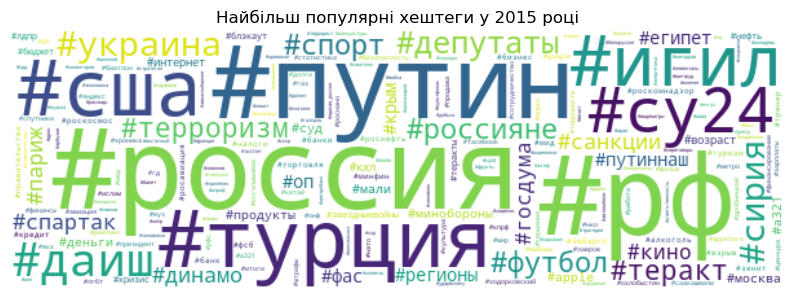

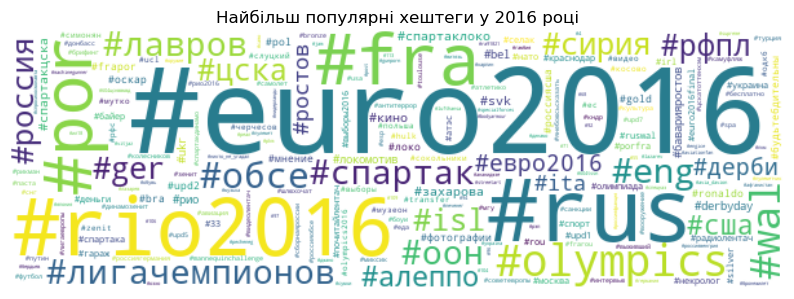

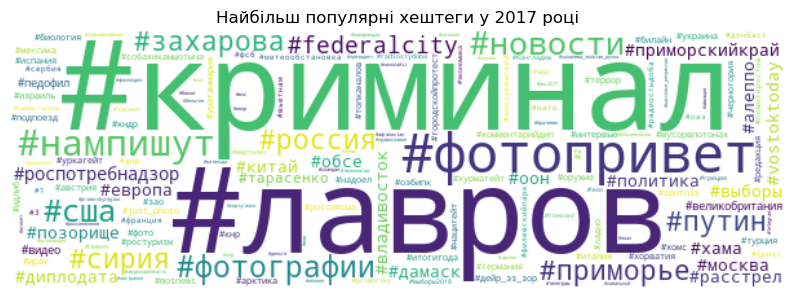

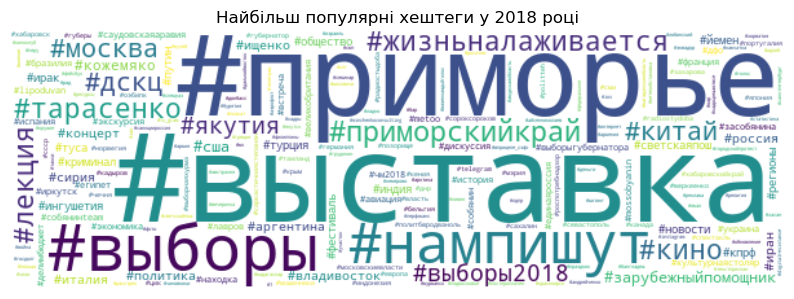

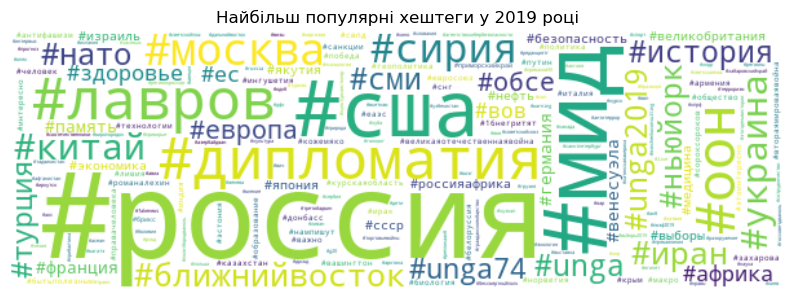

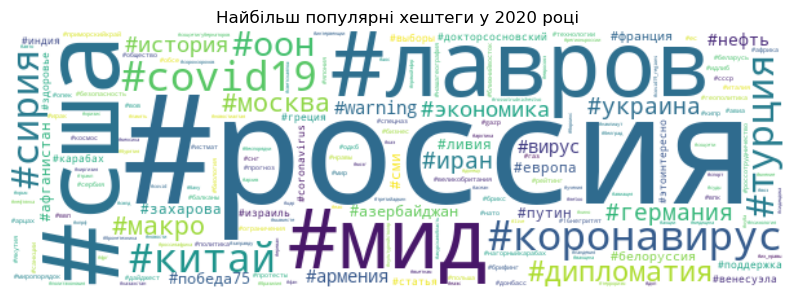

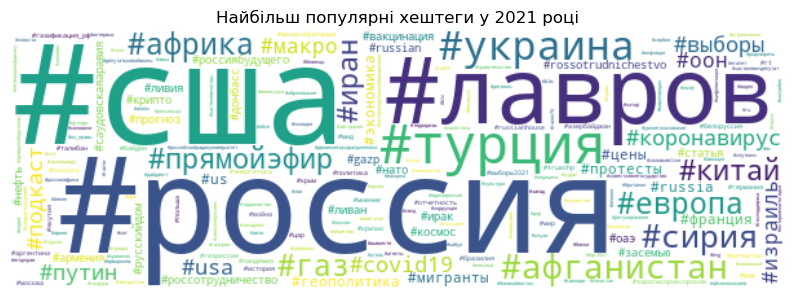

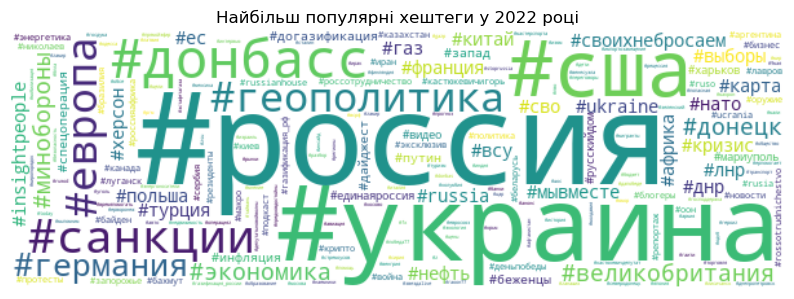

In [33]:
for year in years:
    hashtags_flat = hashtag_counts_pd[hashtag_counts_pd['year'] == year]['lowercase_hash'].explode()

    hashtag_counts = hashtags_flat.value_counts()

    wordcloud = WordCloud(width=600, height=200, background_color="white").generate_from_frequencies(hashtag_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Найбільш популярні хештеги у {year} році')
    plt.show()


У 2015 році найпопулярнішими тегами були Росія, Турція, Іран, Су-24, Сирія. Оскільки в нас дані лише кінця 2015 року, то саме в:
- листопаді 2015 року Турецькі війькові збили російський Су-24 за порушення повітряного простору. 
- 2015 році було досягнуто історичну угоду між Іраном і міжнародними партнерами, включаючи США та Європейський союз, щодо ядерної програми Ірану. Угода передбачала зменшення санкцій у обмін на обмеження ядерної діяльності Ірану.
- цьому році був конфлікт у Сирії, який розпочався у 2011 році, включав у себе різні сторони, а також підтримку президента Сирії Башара Асада з боку Росії, і продовжував тривати й у 2015 році.

У 2016 році всі популярні теги повязані зі сптом (euro-2016, olimpics). Цікаво, що лише в цьому році в хештегах містяться слова іноземною мовою. В цьому році відбулись такі події:
- Євро-2016 в Франції.
- Бразильське місто Ріо-де-Жанейро приймало літні Олімпійські ігри.
- Російська делегація стала об'єктом уваги через широкомасштабний допінг-скандал. Російським атлетам було дозволено брати участь в Олімпійських іграх під нейтральним прапором через санкції за систематичне використання допінгу.

У 2017 році найпопулярнішими були теги криминал, лавров, фотопривет, нампишут, захарова. Головні події того року, які повязані з Лавровим:
- У 2017 році відносини між Росією і Сполученими Штатами були напруженими. Сергій Лавров брав участь у численних зустрічах з американськими колегами, зокрема з Секретарем держави США Рексом Тіллерсоном, де обговорювалися різні глобальні питання.
- Лавров брав активну участь у переговорах із співробітниками інших країн щодо кризи в Сирії. Росія виступала як один з ключових учасників міжнародних зусиль у вирішенні конфлікту.
Питання України:
- Сергій Лавров висловлював позицію Росії щодо ситуації на сході України і обговорював питання безпеки та політичного врегулювання.
-У зв'язку з різними міжнародними подіями, зокрема конфліктом в Україні та ситуацією в Сирії, ряд країн ввів санкції проти Росії. Це було однією з ключових тем обговорення для Лаврова.

У 2018 році в росії були вибори презедента, що чітко прослідковується в ключових тегах. Хештег приморье повязаний з геополітичним становищем Примор'я як прикордонного регіону, та пов'язані з ним російсько-китайськими відносинами або сусідніми країнами, такими як Північна Корея.

У 2019 році головні хештеги також були повязані з міжнародними відносинами росії, а саме:
- Продовження напружених відносин між Росією та Сполученими Штатами, включаючи питання щодо військової присутності в Сирії, збройного конфлікту в Україні та інших глобальних питань.
- Росія продовжувала брати участь у сирійському конфлікті, надаючи підтримку урядові Башара Асада, а також взаємодіючи з іншими учасниками міжнародних переговорів щодо майбутнього Сирії.
- Росія підтримувала уряд Венесуели, який очолював Ніколас Мадуро, в розгортанні кризи в країні, зокрема у відповідь на спроби впливати на внутрішню політику країни з боку інших держав.
- Росія взаємодіяла з іншими країнами у зусиллях щодо вирішення ядерного питання на Корейському півострові, включаючи участь у самітах і переговорах.
- Питання санкцій проти Росії та реакція на них з боку Росії продовжували бути актуальними в міжнародному контексті.
- Розвиток стратегічного партнерства між Росією та Китаєм в різних сферах, включаючи торгівлю, економіку та безпеку.

У 2020 році ми маємо ті ж самі хештеги, які відносяться до віносин на міжнародній арені, країни продовжували вводити санкції, а уряд росії намагався залагодити це питання. Також зявився тег з відношенням до Ковіду, що відповідає до подій в світі повязаних з розповсюдженням цього вірусу.

У 2021 році тег США став найбільшим, ми можемо прослідкувати як збільшувалась кількість постів, які відносяться до нього. На мою думку це повязано з ускладненням відносин між цими країнами, які викликані розвязаною в Україні війною. 

Як ми бачимо хештег з назвою Україна став популярним лише у 2022 році. Також в цьому році зявилися хештеги ВСУ, СВО, 
Своихнебросаем та інших, що відповідає війні розвязаній в Україні.

Також, важливо відмітити, що постів з тегом лавров, більше ніж з тегами які відносяться до презедента путіна. Це може бути повязано, що саме лавров намагався владнати ситуацію росії на міжнародній арені.в більшоб популярністю користувався Лавров.

*Давайте дамо відповідь на запитання щодо емоційності постів в залежності від року та місяця?*

In [47]:
senti_df = filtered_df.select('year', 'month', 'message').na.drop()

In [48]:
# Визначимо UDF для видалення Telegram-specific emojis з тексту
def remove_telegram_emojis_from_text(text):
    if isinstance(text, str):
        # Визначемо регулярні вирази що відповідають Telegram-specific emojis.
        telegram_emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001F004\U0001F0CF\U0001F004\U0001F004\U0001F004\U0001F004\U0001F004\U0001F004]+'
        return re.sub(telegram_emoji_pattern, '', text)
    else:
        return text

analyze_sentiment_emoji_udf = udf(remove_telegram_emojis_from_text, StringType())

# Використаємо UDF, щоб створити нову колонку з видаленими Telegram-specific emojis
senti_df = senti_df.withColumn("text_without_telegram_emojis", analyze_sentiment_emoji_udf(senti_df["message"]))


In [49]:
senti_df.show()

+----+-----+--------------------+----------------------------+
|year|month|             message|text_without_telegram_emojis|
+----+-----+--------------------+----------------------------+
|2022|   12|🇵🇰🇦🇫 Исламаба...|        🇵🇰🇦🇫 Исламаба...|
|2022|   12|🕯️ 6 лет назад, ...|        ️ 6 лет назад, 19...|
|2022|   12|🇮🇷🇷🇺 Глава МИ...|        🇮🇷🇷🇺 Глава МИ...|
|2022|   12|Наши Друзья откры...|        Наши Друзья откры...|
|2022|   12|🇷🇺 Сегодня, 19 ...|        🇷🇺 Сегодня, 19 ...|
|2022|   12|📰📰📰❤️\n\n#Дайд...|        ❤️\n\n#Дайджест_С...|
|2022|   12|🇷🇺🇷🇸🇬🇷 Росс...|        🇷🇺🇷🇸🇬🇷 Росс...|
|2022|   12|🇮🇷🇷🇺 Директор...|        🇮🇷🇷🇺 Директор...|
|2022|   12|🇷🇺🇺🇦 ⚡️⚡️⚡️⚡️...|        🇷🇺🇺🇦 ⚡️⚡️⚡️⚡️...|
|2022|   12|🇮🇳🇪🇺 В Индии ...|        🇮🇳🇪🇺 В Индии ...|
|2022|   12|🇷🇺🇮🇳 16 декаб...|        🇷🇺🇮🇳 16 декаб...|
|2022|   12|Публикуем заявлен...|        Публикуем заявлен...|
|2022|   12|​🇷🇺🗯️ Тг-канал...|        ​🇷🇺️ Тг-канал о...|
|2022|   12|"​​🇺🇸🇯🇵🇷🇺🇨...|        "​​🇺🇸🇯🇵🇷🇺🇨...|
|2022|   12|ТОП-

In [50]:
# Визначемо інші знаки, які необхідно видалити
conditions_to_remove = ['#', '🇷🇺', '🇺🇦', '🇺🇸', '⚡️', '❤️', '📰', '🇮🇷🇷🇺', '🇷🇺🇺🇦', '​🇷🇺', 'https://', '\n', '&', '?', '!', '@']

@udf(StringType())
def remove_specific_conditions(text):
    for cond in conditions_to_remove:
        text = text.replace(cond, '')
    return text

senti_df = senti_df.withColumn("filtered_text", remove_specific_conditions(col("text_without_telegram_emojis"))).drop('message', 'text_without_telegram_emojis')

In [51]:
senti_df = senti_df.dropna(how="any")
senti_df.show()

+----+-----+--------------------+
|year|month|       filtered_text|
+----+-----+--------------------+
|2022|   12|🇵🇰🇦🇫 Исламаба...|
|2022|   12|️ 6 лет назад, 19...|
|2022|   12|🇮🇷 Глава МИД Ир...|
|2022|   12|Наши Друзья откры...|
|2022|   12| Сегодня, 19 дека...|
|2022|   12|Дайджест_СМИ  ABC...|
|2022|   12|🇷🇸🇬🇷 Российск...|
|2022|   12|🇮🇷 Директор Цен...|
|2022|   12| Недавно я писал ...|
|2022|   12|🇮🇳🇪🇺 В Индии ...|
|2022|   12|🇮🇳 16 декабря с...|
|2022|   12|Публикуем заявлен...|
|2022|   12|​️ Тг-канал о вой...|
|2022|   12|"​​🇯🇵🇨🇳 Экспе...|
|2022|   12|ТОП-100 лучших ро...|
|2022|   12| В прямом эфире т...|
|2022|   12|Сегодня Даше Дуги...|
|2022|   12|Дайджест_СМИ  NYT...|
|2022|   12|🇦🇿🇦🇲 Ничего с...|
|2022|   12|  Инфографика: Ко...|
+----+-----+--------------------+
only showing top 20 rows



In [34]:
from textblob import TextBlob

In [53]:
# Define a UDF to calculate sentiment
def analyze_sentiment(text):
    analysis = TextBlob(text)
    sentiment = analysis.sentiment.polarity
    return "позитивний" if sentiment > 0 else "негативний" if sentiment < 0 else "нейтральний"

# Apply the UDF to your DataFrame
sentiment_udf = udf(analyze_sentiment, StringType())
senti_df = senti_df.withColumn("sentiment", sentiment_udf(senti_df["filtered_text"]))

# Show the DataFrame with sentiment analysis results
senti_df.show()

+----+-----+--------------------+-----------+
|year|month|       filtered_text|  sentiment|
+----+-----+--------------------+-----------+
|2022|   12|🇵🇰🇦🇫 Исламаба...|нейтральний|
|2022|   12|️ 6 лет назад, 19...|нейтральний|
|2022|   12|🇮🇷 Глава МИД Ир...|нейтральний|
|2022|   12|Наши Друзья откры...|нейтральний|
|2022|   12| Сегодня, 19 дека...|нейтральний|
|2022|   12|Дайджест_СМИ  ABC...|нейтральний|
|2022|   12|🇷🇸🇬🇷 Российск...|нейтральний|
|2022|   12|🇮🇷 Директор Цен...|нейтральний|
|2022|   12| Недавно я писал ...|нейтральний|
|2022|   12|🇮🇳🇪🇺 В Индии ...|нейтральний|
|2022|   12|🇮🇳 16 декабря с...|нейтральний|
|2022|   12|Публикуем заявлен...|нейтральний|
|2022|   12|​️ Тг-канал о вой...|нейтральний|
|2022|   12|"​​🇯🇵🇨🇳 Экспе...|нейтральний|
|2022|   12|ТОП-100 лучших ро...|нейтральний|
|2022|   12| В прямом эфире т...|нейтральний|
|2022|   12|Сегодня Даше Дуги...|нейтральний|
|2022|   12|Дайджест_СМИ  NYT...|нейтральний|
|2022|   12|🇦🇿🇦🇲 Ничего с...|нейтральний|
|2022|   12|  

In [54]:
count = senti_df.groupBy('year', 'month',"sentiment").count()

In [55]:
sentiment_counts_pd = count.toPandas()

In [56]:
sentiment_counts_pd.to_csv('sentiment.csv')

In [36]:
sentiment_counts_pd = sentiment_counts_pd.loc[sentiment_counts_pd['year'] != 2015]
sentiment_counts_pd

Unnamed: 0  year  month    sentiment   count
0             0  2018      5   негативний     118
1             1  2021     10  нейтральний  130920
2             2  2019      2   негативний     142
3             3  2018     12   негативний     164
4             4  2020      7   негативний     441
..          ...   ...    ...          ...     ...
255         255  2016      1   позитивний       4
256         256  2022      3  нейтральний  342066
257         257  2018     11  нейтральний   38092
258         258  2018      3   негативний     139
259         259  2022     11   позитивний    2767

[252 rows x 5 columns]

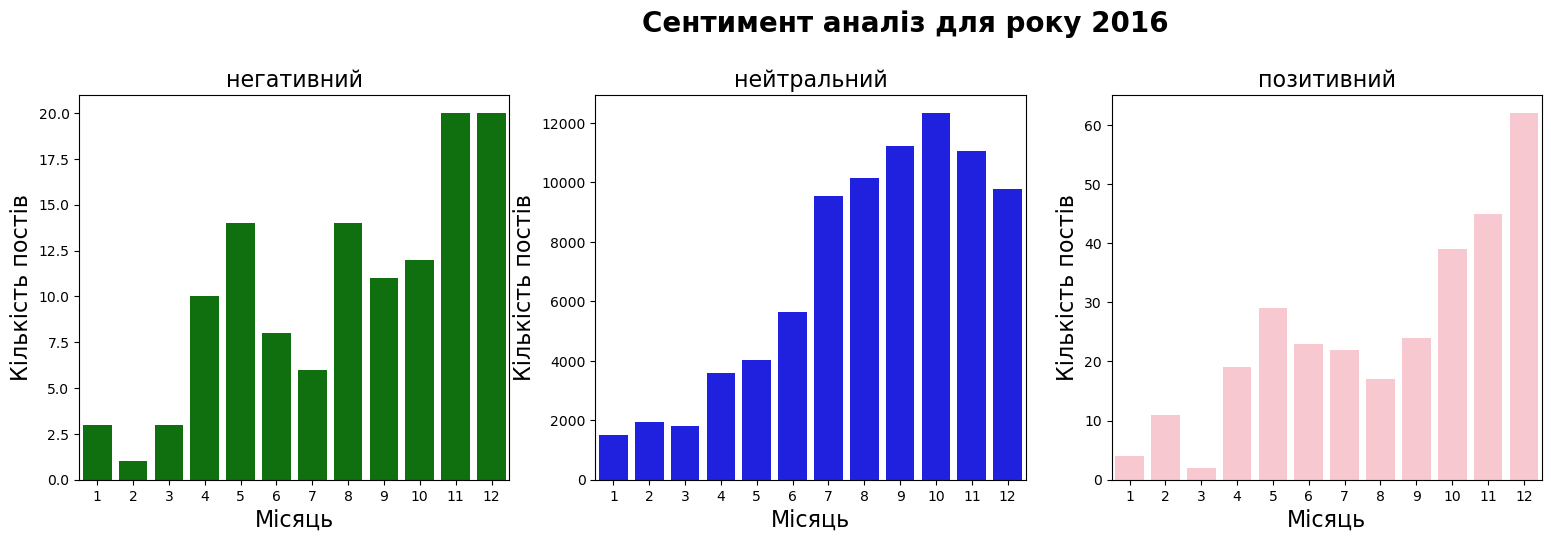

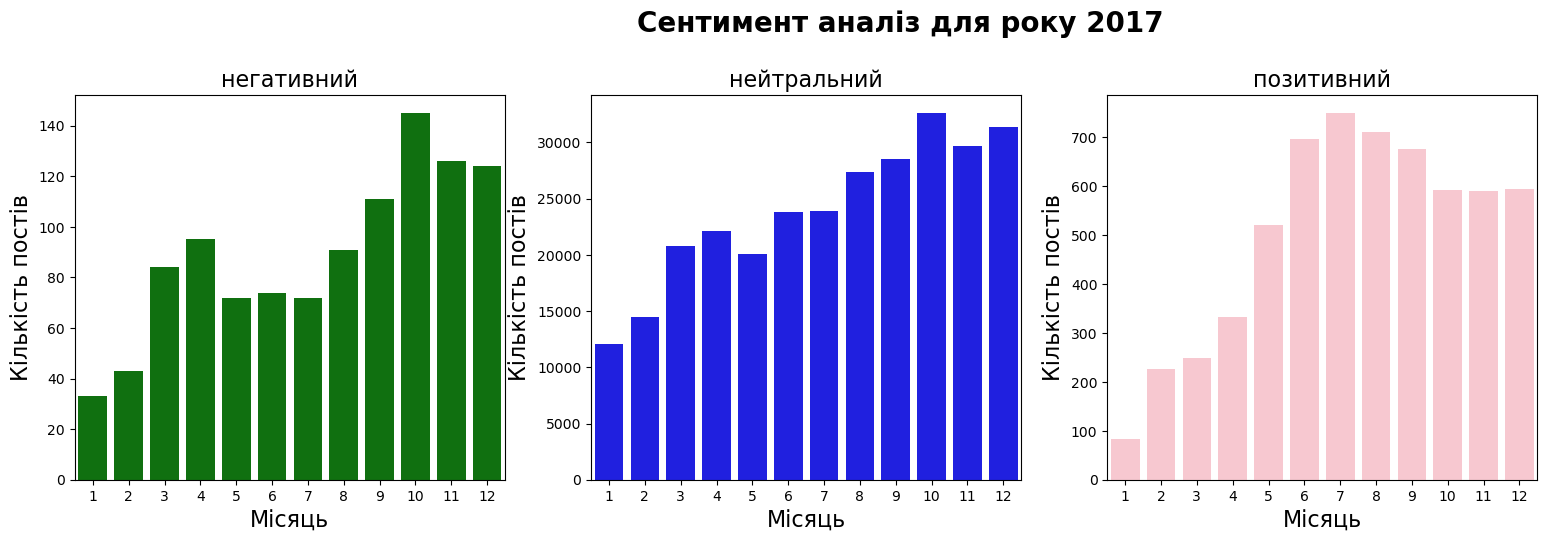

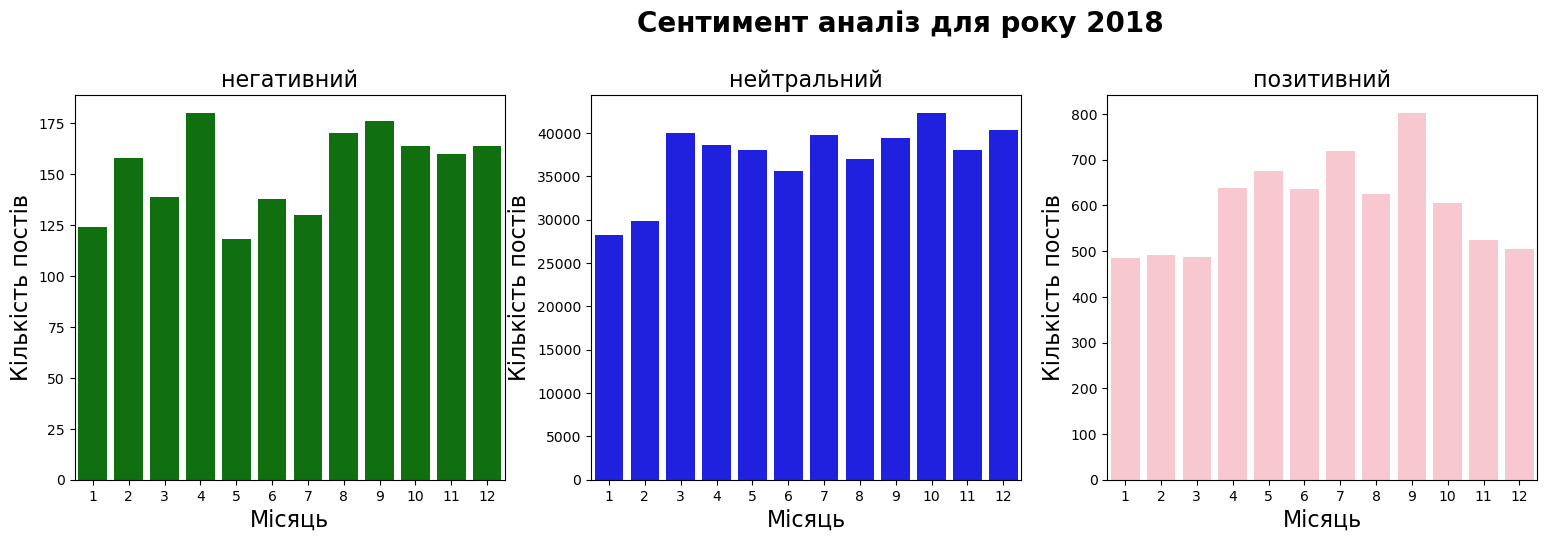

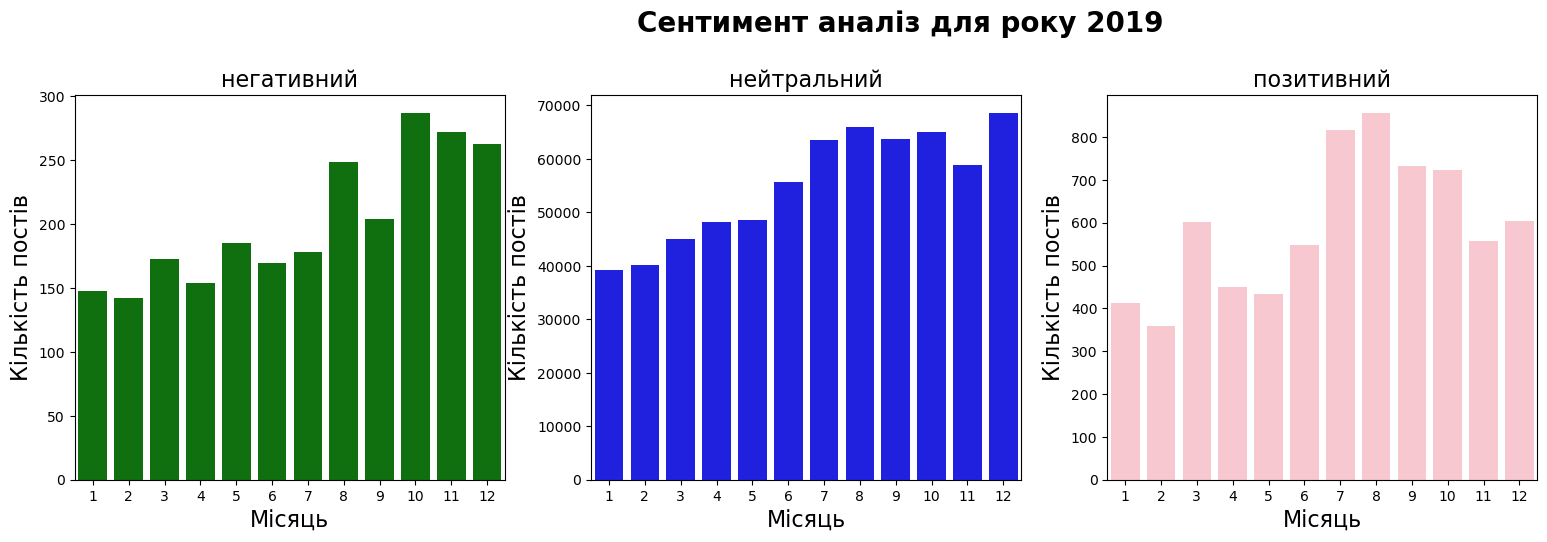

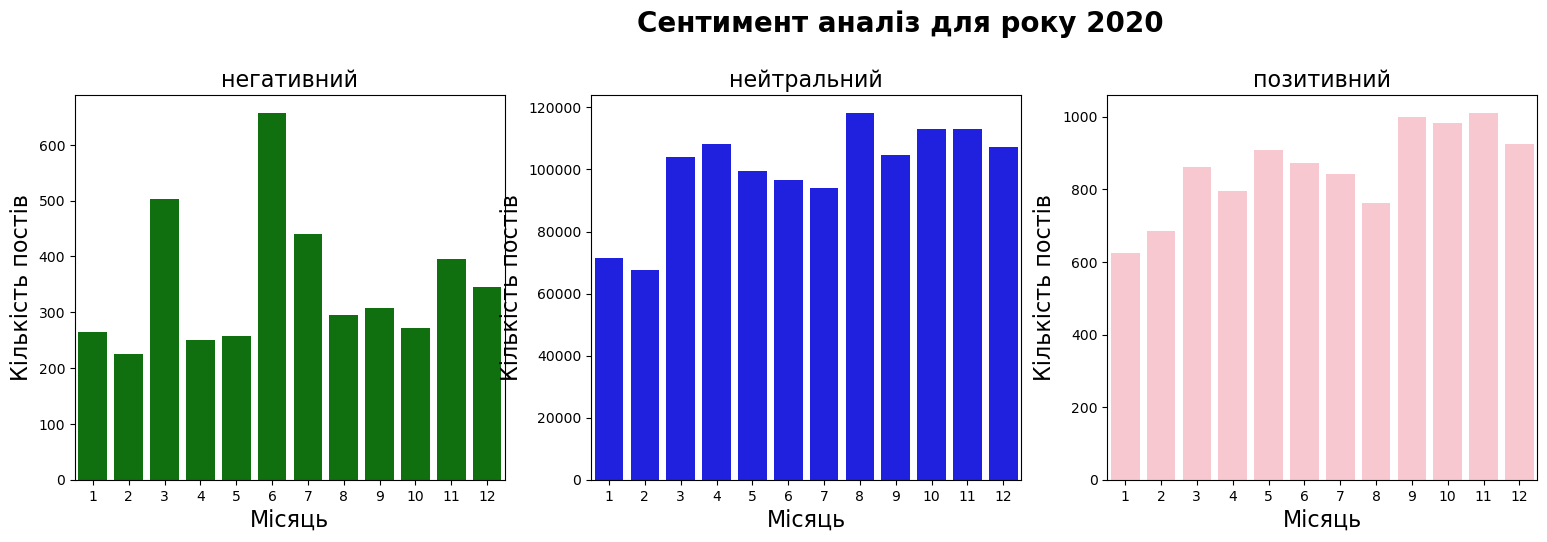

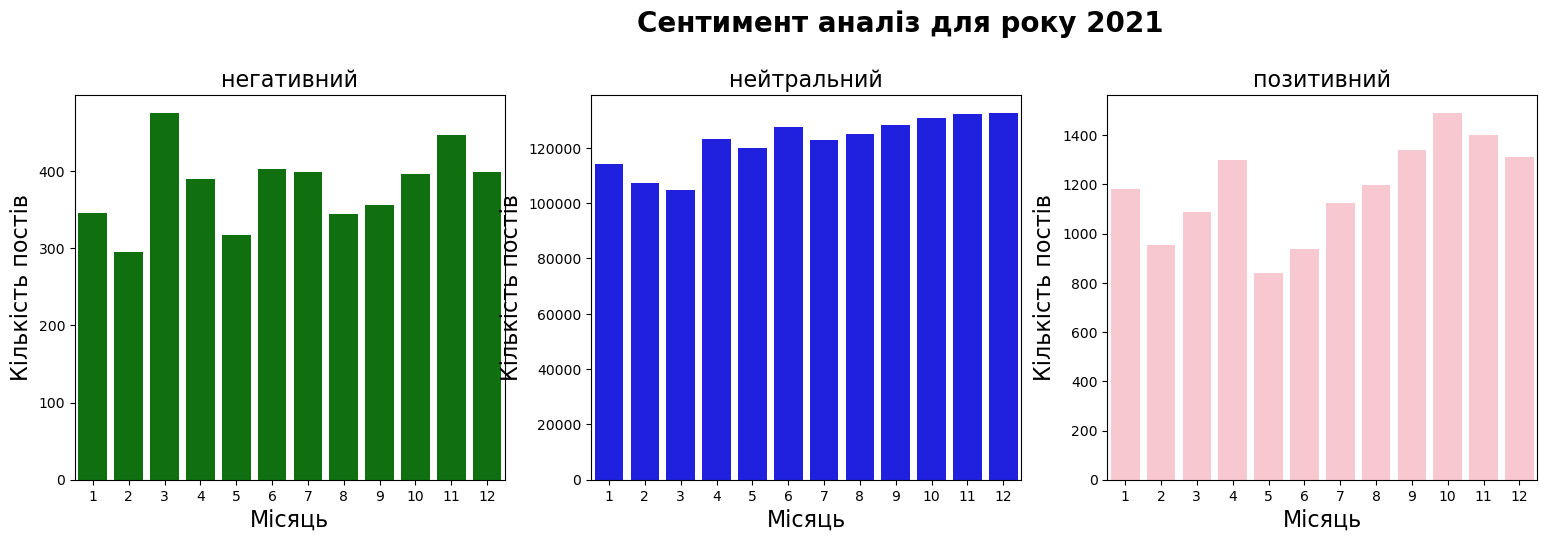

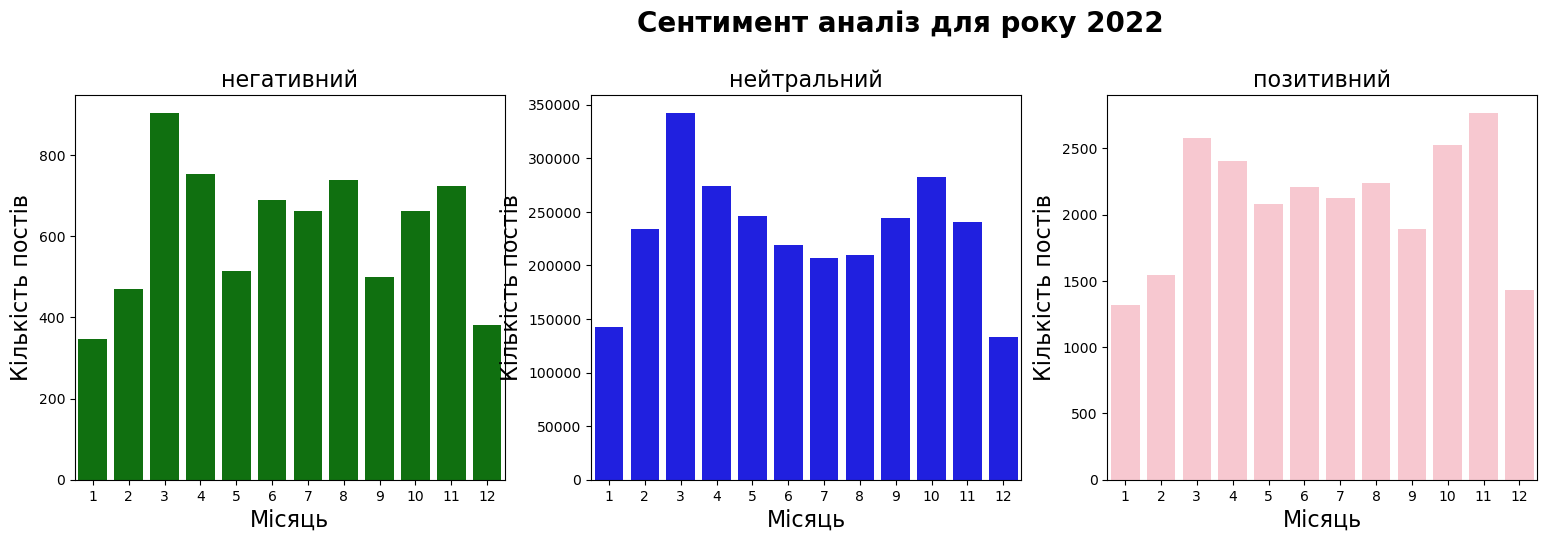

In [37]:
import seaborn as sns

# Assuming you have a DataFrame named sentiment_counts_pd
years = np.sort(sentiment_counts_pd['year'].unique())

color = ['green', 'blue', 'pink']

for year in years:
    year_data = sentiment_counts_pd[sentiment_counts_pd['year'] == year]
    months = year_data['month'].unique()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Сентимент аналіз для року {year}', fontsize=20, ha='left', y=1.05, fontweight='bold')

    for i, sentiment in enumerate(['негативний', 'нейтральний', 'позитивний']):
        ax = axes[i]
        ax.set_title(sentiment, fontsize=16)

        data = {
            'Month': months,
            'Count': [year_data[(year_data['month'] == month) & (year_data['sentiment'] == sentiment)]['count'].values[0] for month in months]
        }

        sns.barplot(x='Month', y='Count', data=data, ax=ax,  color=color[i])

        ax.set_xlabel('Місяць', fontsize=16)
        ax.set_ylabel('Кількість постів', fontsize=16)
      
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=0.2, hspace=2)
    plt.show()


*Отриманий аналіз настроїв в постах в залежності від року, вказує на те, що пости в основному були нейтральні. Можливо треба було використовувати, якусь іншу бібліотеку для аналізу російської мови. Однак, останні чомусь вперто не хотіли установлюватись на мій компютер.
Аналізуючи отримані результати можна сказати, що наприклад, у 2022 році позитивних постів було більше ніж негативних, особливо в березні та листопаді. Можливо вони радувались, що пішли нас 'рятувати'. Цікаво було б подивитись, який розподіл буде за 2023 рік. Хоча видно, що кожного року в них позитивних більше ніж негативних.*

*Давайте дмо відповідь на запитання Яким є розподіл повідомлень за типом (фото, текст, відео)?*

In [38]:
# Визначимо значення для фільтру
values_to_filter = ["photo", "video", "text"]

# Відфільтруємо
filtered_df2 = filtered_df.filter(col("type").isin(values_to_filter))

filtered_df2.show()


+-----+--------------+-------+--------------------+--------------------+--------------------+--------------------+-----+---------------+--------------------+----+-----+
|index|formatted_date|  views|           reactions|               to_id|            fwd_from|             message| type|       hashtags|      filtered_words|year|month|
+-----+--------------+-------+--------------------+--------------------+--------------------+--------------------+-----+---------------+--------------------+----+-----+
|    0|    2022-12-19| 3645.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇵🇰🇦🇫 Исламаба...|photo|             []|[🇵🇰🇦🇫, ислама...|2022|   12|
|    1|    2022-12-19| 5831.0|MessageReactions(...|PeerChannel(chann...|                NULL|🕯️ 6 лет назад, ...|photo|             []|[🕯️, 6, лет, наз...|2022|   12|
|    2|    2022-12-19| 3944.0|MessageReactions(...|PeerChannel(chann...|                NULL|🇮🇷🇷🇺 Глава МИ...|photo|             []|[🇮🇷🇷🇺, глава,...|2022|   12|
|   

In [39]:
type_m = filtered_df2.select('year', 'month', 'type').groupBy('year', 'month', 'type').count().orderBy("year", "month")
type_m_pd = type_m.toPandas()

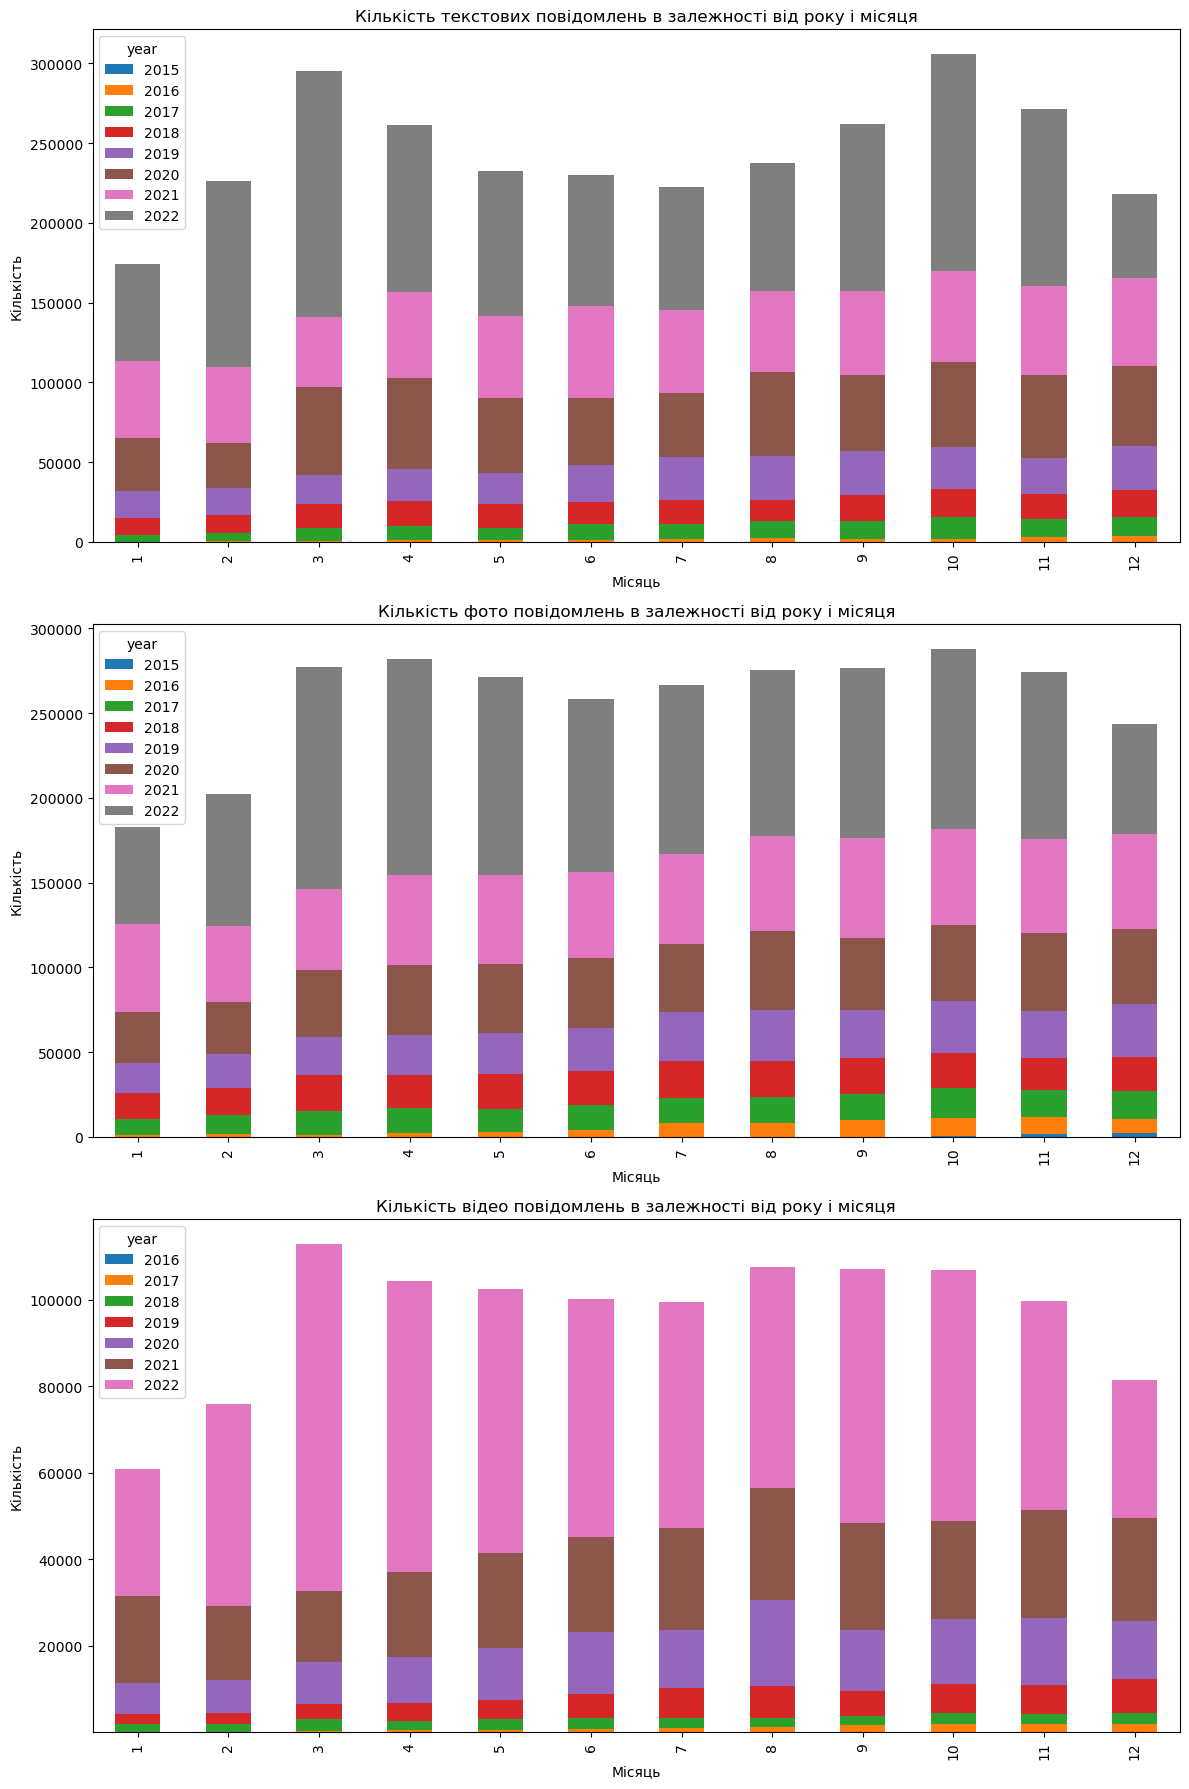

In [40]:
text_data = type_m_pd[type_m_pd['type'] == 'text']
photo_data = type_m_pd[type_m_pd['type'] == 'photo']
video_data = type_m_pd[type_m_pd['type'] == 'video']


fig, axes = plt.subplots(3, 1, figsize=(12, 18))


text_data.pivot_table(index='month', columns='year', values='count', fill_value=0).plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel("Місяць")
axes[0].set_ylabel("Кількість")
axes[0].set_title("Кількість текстових повідомлень в залежності від року і місяця")

photo_data.pivot_table(index='month', columns='year', values='count', fill_value=0).plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel("Місяць")
axes[1].set_ylabel("Кількість")
axes[1].set_title("Кількість фото повідомлень в залежності від року і місяця")

video_data.pivot_table(index='month', columns='year', values='count', fill_value=0).plot(kind='bar', stacked=True, ax=axes[2])
axes[2].set_xlabel("Місяць")
axes[2].set_ylabel("Кількість")
axes[2].set_title("Кількість відео повідомлень в залежності від року і місяця")

plt.tight_layout()
plt.show()

*З отриманих результатів видно, що найбільша кількість відео повідомлень була у березні 2022 року. Що скоріше за все повязано саме з початком війни проти України. На мою думку саме в цих відеоповідомленнях російському народу хотіли показати, як Україна бомбить себе сама. Також саме в цей час найбільша кількість повідомлень текстових. Можна зробити гіпотезу, що приблизно такий самий розподіл типів повідомлень буде саме в Україні в цей час. Також, необхідно відмітити, що кількість фото повідомлень майже однакова у всіх роках.*
